PNEUMOTHORAX SEGMENTATION USING SIIM-ACR DATASET

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
!pip install einops


## Importing Libraries

In [3]:
import os
import torch
import csv
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import json
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import Sampler
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import torchvision.models as models # NEW MARCH-JUNE EDIT

try:
    from itertools import ifilterfalse
except ImportError:  # py3k
    from itertools import filterfalse

In [4]:
def init_seed(SEED=42):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [5]:
init_seed()

## Config - 1

In [6]:
IMG_SIZE         = 512 # This is efficient and better for the completion of the project
WHOSE_DIR        = "wonder_boys"

if WHOSE_DIR == "Aathesh":
    DIR              = "C:\\Users\\aathe\\Google Drive - Wonder Boys\\Colab_Notebooks\\datasets\\main"
    DATA_DIR         = Path(DIR)
    TRAIN_IMG_DIR    = Path("C:\\Users\\aathe\\Google Drive - Wonder Boys\\Colab_Notebooks\\datasets\\main\\train_png")
    TRAIN_LBL_DIR    = Path("C:\\Users\\aathe\\Google Drive - Wonder Boys\\Colab_Notebooks\\datasets\\main\\mask")
    DATA_FRAME_PATH  = "C:\\Users\\aathe\\Google Drive - Wonder Boys\\Colab_Notebooks\\datasets\\main\\RLE_kfold.csv"
elif WHOSE_DIR == "Neeshanth":
    DIR              = "/content/drive/MyDrive/datasets"
    DATA_DIR         = Path(DIR)
    TRAIN_IMG_DIR    = Path("/content/drive/MyDrive/datasets/train_png")
    TRAIN_LBL_DIR    = Path("/content/drive/MyDrive/datasets/mask")
    DATA_FRAME_PATH  = "/content/drive/MyDrive/datasets/RLE_kfold.csv"

elif WHOSE_DIR == "Kousik":
    DIR              = r"C:\Users\kousi\Downloads\datasets"
    DATA_DIR         = Path(DIR)
    TRAIN_IMG_DIR    = Path(r"C:\Users\kousi\Downloads\datasets\train_png")
    TRAIN_LBL_DIR    = Path(r"C:\Users\kousi\Downloads\datasets\mask")
    DATA_FRAME_PATH  = r"C:\Users\kousi\Downloads\datasets\RLE_kfold.csv"

elif WHOSE_DIR == "wonder_boys":
    DIR              = "/content/drive/MyDrive/Colab_Notebooks/datasets/main"
    DATA_DIR         = Path(DIR)
    TRAIN_IMG_DIR    = Path("/content/drive/MyDrive/Colab_Notebooks/datasets/main/train_png")
    TRAIN_LBL_DIR    = Path("/content/drive/MyDrive/Colab_Notebooks/datasets/main/mask")
    DATA_FRAME_PATH  = "/content/drive/MyDrive/Colab_Notebooks/datasets/main/RLE_kfold.csv"

KFOLD_PATH       = ""
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
BATCH_SIZE       = 8
EPOCHS           = 50
# Path for pretrained model weights
TRAINING_MODEL_PATH = "/content/drive/MyDrive/m_512_CHECKPOINTS_epoch2_bst_model512_fold4_0.7942000031471252.tar"
USE_SAMPLER      = True
POSTIVE_PERC     = 0.5
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED       = True # False means we're using ImageNet weights, so essentially, it's pretrained & never from scratch!!!!!
LEARNING_RATE    = 0.00001
NUM_WORKERS      = 8
USE_CRIT         = True
FOLD_ID          = 4
EVAL_METRICS      = ["metric - it calculates dice coefficient."]

# Regularization Settings
EARLY_STOPPING_PATIENCE = 12
L2_WEIGHT_DECAY  = 0.000005
GRADIENT_CLIPPING = True
GRADIENT_CLIPPING_THRESHOLD = 0.1

# IF U DON'T WANT TO CHANGE Learning rate from previous experiment then set this to True.
OPTIMIZER_LOAD = False
# U MUST VERIFY IF LR IS GETTING SET PROPERLY FOR THE SCHEDULER IN THE "OPTIMIZER & SCHEDULER" SECTION OF THE NOTEBOOK.

# Learning Rate Scheduler Settings
SCHEDULER        = "CosineAnnealingWarmRestarts"
if SCHEDULER == "ReduceLROnPlateau":
    SCHEDULER_PARAMS = {'factor': 0.1, 'patience': 2, 'threshold': 0.0000001, 'min_lr': 0.0000001} # patience changed from 2 to 1 on 12-04-2025
elif SCHEDULER == "CosineAnnealingWarmRestarts":
    SCHEDULER_PARAMS = {'T_0': 1, 'T_mult': 2, 'eta_min': 0.0000001}
elif SCHEDULER == "CosineAnnealingLR":
    SCHEDULER_PARAMS = {'T_max': 8, 'eta_min': 0.0000001}

# Thresholds for 1024x1024 is there along with div by 2 values and div by 4 values
TRIPLET_THRESHOLDS = [  [0.6, 500.0, 0.35], [0.67, 500.0, 0.37], [0.75, 500.0, 0.3],
                        [0.75, 500.0, 0.4], [0.75, 1000.0, 0.3], [0.75, 1000.0, 0.4],
                        [0.6, 1000.0, 0.3], [0.6, 1000.0, 0.4], [0.6, 1500.0, 0.3],
                        [0.6, 1500.0, 0.4], [0.6, 250.0, 0.35], [0.67, 250.0, 0.37],
                        [0.75, 250.0, 0.3], [0.75, 250.0, 0.4], [0.75, 500.0, 0.3],
                        [0.75, 500.0, 0.4], [0.6, 500.0, 0.3], [0.6, 500.0, 0.4],
                        [0.6, 750.0, 0.3], [0.6, 750.0, 0.4], [0.6, 1000, 0.35],
                        [0.67, 1000, 0.37], [0.75, 1000, 0.3], [0.75, 1000, 0.4],
                        [0.75, 2000, 0.3], [0.75, 2000, 0.4], [0.6, 2000, 0.3],
                        [0.6, 2000, 0.4], [0.6, 3000, 0.3], [0.6, 3000, 0.4]       ]


"""
    "-------------------------------SAVING losses & metrics-------------------------------------"
"""
ACCOUNT         = "wonder_boys" # "Neeshanth" or "wonder_boys" or others
PURPOSE         = "Project-2" # training/inference/hyperparameter-tuning or hpt OR ANYTHING MORE SPECIFIC
EXP_NO          = "Novel_Algo_6" # hpt experiment with changed settings
PHASE           = "16_04_2025" # Just date

EFFECTIVE_BATCH_SIZE = 8 # accumulation_steps * BATCH_SIZE

if ACCOUNT == "Neeshanth":
    # Save Config.txt
    CONFIG_FILE_LOC = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/Config.txt"

    # Save model checkpoint using early stopping class
    model_checkpoint_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/m_{IMG_SIZE}_CHECKPOINTS"

    # Save batch wise comboloss during training
    store_batch_training_details_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_train_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_" # epoch no. will be added to the end

    # Save batch wise comboloss during validation
    store_batch_validation_details_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_vali_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch wise train and val losses to monitor overfitting
    save_progress_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_progress.csv"

    # Save epoch wise dice coefficient
    save_dice_score_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_dice_scores.csv"

    # Save bce, dice & focal losses separately after training is done
    save_3losses_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_all_loss_values.csv"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_best_checkpoint_thresholds.csv"

if ACCOUNT == "Kousik":
    # Save Config.txt
    CONFIG_FILE_LOC = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\Config.txt"

    # Save model checkpoint using early stopping class
    model_checkpoint_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\m_{IMG_SIZE}_CHECKPOINTS"

    # Save batch-wise comboloss during training
    store_batch_training_details_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\{EXP_NO}_train_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_"  # epoch no. will be added to the end

    # Save batch-wise comboloss during validation
    store_batch_validation_details_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\{EXP_NO}_vali_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch-wise train and val losses to monitor overfitting
    save_progress_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\{EXP_NO}_progress.csv"

    # Save epoch-wise dice coefficient
    save_dice_score_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\{EXP_NO}_dice_scores.csv"

    # Save BCE, dice & focal losses separately after training is done
    save_3losses_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\{EXP_NO}_all_loss_values.csv"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = rf"E:\Project Metrics\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\{EXP_NO}_best_checkpoint_thresholds.csv"


if ACCOUNT == "wonder_boys":
    # Save Config.txt file
    CONFIG_FILE_LOC = f"/content/drive/MyDrive/Saved Models/ViT_Model/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/Config.txt"

    # Save model checkpoint using early stopping class
    model_checkpoint_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/m_{IMG_SIZE}_CHECKPOINTS"

    # Save batch wise comboloss during training
    store_batch_training_details_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_train_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_" # epoch no. will be added to the end

    # Save batch wise comboloss during validation
    store_batch_validation_details_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_vali_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch wise train and val losses to monitor overfitting
    save_progress_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_progress.csv"

    # Save epoch wise dice coefficient
    save_dice_score_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_dice_scores.csv"

    # Save bce, dice & focal losses separately after training is done
    save_3losses_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_all_loss_values.csv"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = f"/content/drive/MyDrive/Saved Models/i/{PURPOSE}_EXP_{EXP_NO}_{PHASE}/{EXP_NO}_best_checkpoint_thresholds.csv"

if ACCOUNT == "pc_aathesh":
    # Save Config.txt file
    CONFIG_FILE_LOC = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}/Config.txt"

    # Save batch wise comboloss during training
    store_batch_training_details_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\CHECKPOINTS"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_" # epoch no. will be added to the end

    # Save batch wise comboloss during validation
    store_batch_validation_details_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\{PURPOSE}_vali_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch wise train and val losses to monitor overfitting
    save_progress_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\{PURPOSE}_progress.csv"

    # Save epoch wise dice coefficient
    save_dice_score_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\{PURPOSE}_dice_score.csv"

    # Save bce, dice & focal losses separately after training is done
    save_3losses_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\{PURPOSE}_all_loss_vals.csv"

    # Save model checkpoint using early stopping class - CREATE A NEW FOLDER
    model_checkpoint_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\m_{IMG_SIZE}_CHECKPOINTS"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\{PURPOSE}_EXP_{EXP_NO}_{PHASE}\\{PURPOSE}_best_checkpoint_thresholds.csv"

## Saving Config as .txt - TYPE ESSENTIAL DETAILS TO RECOVER THIS EXPERIMENT IN THE BELOW SNIPPET

ESSENTIALS include current_notebook_loc_in_pc, previous_notebook_loc_in_pc, key_changes

In [ ]:
from datetime import datetime
import pytz

# Define the IST timezone
ist_timezone = pytz.timezone('Asia/Kolkata')

# Get the current time in IST
ist_time = datetime.now(ist_timezone)

# Format the date and time to DD-MM-YYYY HH:MM:SS
formatted_ist_time = ist_time.strftime("%d-%m-%Y %H:%M:%S")

# Print the formatted IST time
print("Current IST date and time is:", formatted_ist_time)


Current IST date and time is: 14-04-2025 22:01:58


In [ ]:
hyperparameters = {
    'image_size': f"{IMG_SIZE}x{IMG_SIZE}",
    'date': formatted_ist_time,
    'account': ACCOUNT,
    'purpose': PURPOSE,
    'experiment_no': EXP_NO,
    'key_changes': "batch_size=3, initial LR=0.0001 and patience of scheduler is 2 not 1 and mode is max not min",
    'checkpoint_used_loc': TRAINING_MODEL_PATH,
    'is_optimizer_loaded': OPTIMIZER_LOAD,
    'learning_rate': LEARNING_RATE,
    'batch_size': EFFECTIVE_BATCH_SIZE,
    'gradient_accumulation_steps': int(EFFECTIVE_BATCH_SIZE/BATCH_SIZE),
    'num_epochs': EPOCHS,
    'IsSamplerUsed': USE_SAMPLER,
    'percentage_of_positive_samples': POSTIVE_PERC,
    'optimizer': 'Adam',
    'loss_function': 'ComboLoss',
    'scheduler': SCHEDULER,
    'scheduler_params': SCHEDULER_PARAMS,
    'L2_Regularization_weight_decay':L2_WEIGHT_DECAY,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'is_gradient_clipping_used': GRADIENT_CLIPPING,
    'gradient_clipping_threshold': GRADIENT_CLIPPING_THRESHOLD,
    'model': 'Hybrid Vision Transformer',
    'training_phase': f"Phase - {PHASE}",
    'fold_ID': FOLD_ID,
    'GPU_name': torch.cuda.get_device_name(torch.cuda.current_device()),
    'num_workers': NUM_WORKERS,
    'weights_given_to_loss_functions': {'bce': 3, 'dice': 1, 'focal': 4},
    'triplet_thresholds': TRIPLET_THRESHOLDS,
    'evaluation_metrics': EVAL_METRICS,
}

# Convert the dictionary to a formatted string
hyperparameters_str = json.dumps(hyperparameters, indent=4)

# Specify the file name
file_name = CONFIG_FILE_LOC

os.makedirs(os.path.dirname(file_name), exist_ok=True)

# Write the string to a file
with open(file_name, 'w') as file:
    file.write(hyperparameters_str)

print(f"Hyper-parameters have been saved to {file_name}")


Hyper-parameters have been saved to /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/Config.txt


## Losses

In [7]:
bce_losses = []
dice_losses = []
focal_losses = []

In [8]:
import torch
from torch.nn import functional as F
import numpy as np
from scipy.ndimage import distance_transform_edt as distance
from skimage import segmentation as skimage_seg


def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss


def dice_loss1(score, target):
    # non-square
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target)
    z_sum = torch.sum(score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss


def iou_loss(score, target):
    target = target.float()
    smooth = 1e-5
    tp_sum = torch.sum(score * target)
    fp_sum = torch.sum(score * (1 - target))
    fn_sum = torch.sum((1 - score) * target)
    loss = (tp_sum + smooth) / (tp_sum + fp_sum + fn_sum + smooth)
    loss = 1 - loss
    return loss


def entropy_loss(p, C=2):
    ## p N*C*W*H*D
    y1 = -1 * torch.sum(p * torch.log(p + 1e-6), dim=1) / torch.tensor(
        np.log(C)).cuda()
    ent = torch.mean(y1)

    return ent


def softmax_dice_loss(input_logits, target_logits):
    """Takes softmax on both sides and returns MSE loss
    Note:
    - Returns the sum over all examples. Divide by the batch size afterwards
      if you want the mean.
    - Sends gradients to inputs but not the targets.
    """
    assert input_logits.size() == target_logits.size()
    input_softmax = F.softmax(input_logits, dim=1)
    target_softmax = F.softmax(target_logits, dim=1)
    n = input_logits.shape[1]
    dice = 0
    for i in range(0, n):
        dice += dice_loss1(input_softmax[:, i], target_softmax[:, i])
    mean_dice = dice / n

    return mean_dice


def entropy_loss_map(p, C=2):
    ent = -1 * torch.sum(p * torch.log(p + 1e-6), dim=1,
                         keepdim=True) / torch.tensor(np.log(C)).cuda()
    return ent


def softmax_mse_loss(input_logits, target_logits):
    """Takes softmax on both sides and returns MSE loss
    Note:
    - Returns the sum over all examples. Divide by the batch size afterwards
      if you want the mean.
    - Sends gradients to inputs but not the targets.
    """
    assert input_logits.size() == target_logits.size()
    input_softmax = F.softmax(input_logits, dim=1)
    target_softmax = F.softmax(target_logits, dim=1)

    mse_loss = (input_softmax - target_softmax)**2
    return mse_loss


def softmax_kl_loss(input_logits, target_logits):
    """Takes softmax on both sides and returns KL divergence
    Note:
    - Returns the sum over all examples. Divide by the batch size afterwards
      if you want the mean.
    - Sends gradients to inputs but not the targets.
    """
    assert input_logits.size() == target_logits.size()
    input_log_softmax = F.log_softmax(input_logits, dim=1)
    target_softmax = F.softmax(target_logits, dim=1)

    # return F.kl_div(input_log_softmax, target_softmax)
    kl_div = F.kl_div(input_log_softmax, target_softmax, reduction='none')
    # mean_kl_div = torch.mean(0.2*kl_div[:,0,...]+0.8*kl_div[:,1,...])
    return kl_div


def symmetric_mse_loss(input1, input2):
    """Like F.mse_loss but sends gradients to both directions
    Note:
    - Returns the sum over all examples. Divide by the batch size afterwards
      if you want the mean.
    - Sends gradients to both input1 and input2.
    """
    assert input1.size() == input2.size()
    return torch.mean((input1 - input2)**2)


def compute_sdf01(segmentation):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM)
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """
    # print(type(segmentation), segmentation.shape)

    segmentation = segmentation.astype(np.uint8)

    if len(segmentation.shape) == 4:  # 3D image
        segmentation = np.expand_dims(segmentation, 1)
    normalized_sdf = np.zeros(segmentation.shape)
    if segmentation.shape[1] == 1:
        dis_id = 0
    else:
        dis_id = 1
    for b in range(segmentation.shape[0]):  # batch size
        for c in range(dis_id, segmentation.shape[1]):  # class_num
            # ignore background
            posmask = segmentation[b][c]
            if np.max(posmask) == 0:
                continue
            negmask = ~posmask
            posdis = distance(posmask)
            negdis = distance(negmask)
            boundary = skimage_seg.find_boundaries(
                posmask, mode='inner').astype(np.uint8)
            sdf = negdis / np.max(negdis) / 2 - posdis / np.max(
                posdis) / 2 + 0.5
            sdf[boundary > 0] = 0.5
            normalized_sdf[b][c] = sdf
    return normalized_sdf


def compute_sdf1_1(segmentation):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM)
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """
    # print(type(segmentation), segmentation.shape)

    segmentation = segmentation.astype(np.uint8)
    if len(segmentation.shape) == 4:  # 3D image
        segmentation = np.expand_dims(segmentation, 1)
    normalized_sdf = np.zeros(segmentation.shape)
    if segmentation.shape[1] == 1:
        dis_id = 0
    else:
        dis_id = 1
    for b in range(segmentation.shape[0]):  # batch size
        for c in range(dis_id, segmentation.shape[1]):  # class_num
            # ignore background
            posmask = segmentation[b][c]
            if np.max(posmask) == 0:
                continue
            negmask = ~posmask
            posdis = distance(posmask)
            negdis = distance(negmask)
            boundary = skimage_seg.find_boundaries(
                posmask, mode='inner').astype(np.uint8)
            sdf = negdis / np.max(negdis) - posdis / np.max(posdis)
            sdf[boundary > 0] = 0
            normalized_sdf[b][c] = sdf
    return normalized_sdf


def compute_fore_dist(segmentation):
    """
    compute the foreground of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM)
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """
    # print(type(segmentation), segmentation.shape)

    segmentation = segmentation.astype(np.uint8)
    if len(segmentation.shape) == 4:  # 3D image
        segmentation = np.expand_dims(segmentation, 1)
    normalized_sdf = np.zeros(segmentation.shape)
    if segmentation.shape[1] == 1:
        dis_id = 0
    else:
        dis_id = 1
    for b in range(segmentation.shape[0]):  # batch size
        for c in range(dis_id, segmentation.shape[1]):  # class_num
            # ignore background
            posmask = segmentation[b][c]
            posdis = distance(posmask)
            normalized_sdf[b][c] = posdis / np.max(posdis)
    return normalized_sdf


def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp


def AAAI_sdf_loss(net_output, gt):
    """
    net_output: net logits; shape=(batch_size, class, x, y, z)
    gt: ground truth; (shape (batch_size, 1, x, y, z) OR (batch_size, x, y, z))
    """
    smooth = 1e-5
    axes = tuple(range(2, len(net_output.size())))
    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)
        gt_sdm_npy = compute_sdf1_1(y_onehot.cpu().numpy())
        if net_output.device.type == "cuda":
            gt_sdm = torch.from_numpy(gt_sdm_npy).float().cuda(
                net_output.device.index)
        else:
            gt_sdm = torch.from_numpy(gt_sdm_npy).float()
    intersect = sum_tensor(net_output * gt_sdm, axes, keepdim=False)
    pd_sum = sum_tensor(net_output**2, axes, keepdim=False)
    gt_sum = sum_tensor(gt_sdm**2, axes, keepdim=False)
    L_product = (intersect + smooth) / (intersect + pd_sum + gt_sum)
    # print('L_product.shape', L_product.shape) (4,2)
    L_SDF_AAAI = -L_product.mean() + torch.norm(net_output - gt_sdm,
                                                1) / torch.numel(net_output)

    return L_SDF_AAAI


def sdf_kl_loss(net_output, gt):
    """
    net_output: net logits; shape=(batch_size, class, x, y, z)
    gt: ground truth; (shape (batch_size, 1, x, y, z) OR (batch_size, x, y, z))
    """
    smooth = 1e-5
    axes = tuple(range(2, len(net_output.size())))
    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)
        # print('y_onehot.shape', y_onehot.shape)
        gt_sdf_npy = compute_sdf(y_onehot.cpu().numpy())
        gt_sdf = torch.from_numpy(gt_sdf_npy + smooth).float().cuda(
            net_output.device.index)
    # print('net_output, gt_sdf', net_output.shape, gt_sdf.shape)
    # exit()
    sdf_kl_loss = F.kl_div(net_output,
                           gt_sdf[:, 1:2, ...],
                           reduction='batchmean')

    return sdf_kl_loss

In [9]:
eps = 1e-6


def soft_dice_loss(outputs, targets, per_image=False, per_channel=False):
    """
        If per_image = False, then the function calculates dice loss for a single image-mask pair.
    """
    batch_size, n_channels = outputs.size(0), outputs.size(1)

    eps = 1e-6
    n_parts = 1
    if per_image:
        n_parts = batch_size
    if per_channel:
        n_parts = batch_size * n_channels

    dice_target = targets.contiguous().view(n_parts, -1).float()
    dice_output = outputs.contiguous().view(n_parts, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1)
    loss = (1 - (2 * intersection + eps) / (union + eps)) # returns a tensor of size [8]
    return loss.mean() # returns a tensor of size [1].

def dice_metric(preds, trues, per_image=False, per_channel=False):
    preds = preds.float()
    return 1 - soft_dice_loss(preds, trues, per_image, per_channel)


def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        dice_loss = soft_dice_loss(input, target, per_image=self.per_image)
        dice_losses.append(dice_loss.item())
        return dice_loss


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False, non_empty=False, apply_sigmoid=False,
                 min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)

class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, logits, target):
        bce_loss_with_logits = nn.BCEWithLogitsLoss(reduction='mean') # mean is taken across batches
        bce_loss = bce_loss_with_logits(logits, target)
        bce_losses.append(bce_loss.item())
        return bce_loss # returns a tensor of size [1]


class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=True, channel_weights=[1, 0.5, 0.5], channel_losses=None):
        super().__init__()
        self.weights = weights
        self.bce = StableBCELoss()
        self.dice = DiceLoss(per_image=True)
        self.jaccard = JaccardLoss(per_image=True)
        self.lovasz = LovaszLoss(per_image=per_image)
        self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {'bce': self.bce,
                        'dice': self.dice,
                        'focal': self.focal,
                        'jaccard': self.jaccard,
                        'lovasz': self.lovasz,
                        'lovasz_sigmoid': self.lovasz_sigmoid}
        self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
        self.per_channel = {'dice', 'jaccard', 'lovasz_sigmoid'}
        self.values = {}
        self.channel_weights = channel_weights
        self.channel_losses = channel_losses

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        for k, v in weights.items():
            if not v:
                continue
            val = 0
            if k in self.per_channel:
                channels = targets.size(1)
                for c in range(channels):
                    if not self.channel_losses or k in self.channel_losses[c]:
                        val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...],
                                               targets[:, c, ...])

            else:
                val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

            self.values[k] = val
            loss += self.weights[k] * val
        return loss.clamp(min=1e-5)


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts.float() - gt_sorted.float().cumsum(0)
    union = gts.float() + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                    for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_sigmoid(probas, labels, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(prob.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(probas, labels, ignore))
    return loss


def lovasz_sigmoid_flat(probas, labels):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    fg = labels.float()
    errors = (Variable(fg) - probas).abs()
    errors_sorted, perm = torch.sort(errors, 0, descending=True)
    perm = perm.data
    fg_sorted = fg[perm]
    loss = torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted)))
    return loss

def symmetric_lovasz(outputs, targets, ):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class LovaszLoss(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return symmetric_lovasz(outputs, targets)

class LovaszLossSigmoid(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_sigmoid(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)

class FocalLoss2d(nn.Module):
    def __init__(self, alpha=0.65, gamma=2,n_parts=BATCH_SIZE):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.n_parts = n_parts

    def forward(self, outputs, targets):
        n_parts = self.n_parts
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        eps = 1e-6
        # non_ignored = targets.view(n_parts, -1) != self.ignore_index
        targets = targets.view(n_parts, -1).float()
        outputs = outputs.view(n_parts, -1)
        # clamp just makes sure the values of the tensor is within the given range.
        outputs = torch.clamp(outputs, eps, 1. - eps)
        targets = torch.clamp(targets, eps, 1. - eps)
        """ pt = predicted probability for the true class
        when targets = 1, pt = outputs which means pt now has the predicted probability of positive class.
        when tagets = 0, pt = 1 - outputs which means pt has the predicted probability of negative class.
        """
        pt = (1 - targets) * (1 - outputs) + targets * outputs
        alpha_t = self.alpha * targets + (1 - self.alpha)*(1 - targets)
        pt_proc = -(alpha_t*((1. - pt) ** self.gamma * torch.log(pt))) # torch.log is natural log
        focal_loss = pt_proc.mean(dim=1).mean()
        focal_losses.append(focal_loss.item())
        return focal_loss

## Config - 2

In [10]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--arch', type=str, default='BAT')
parser.add_argument('--gpu', type=str, default='1')
parser.add_argument('--net_layer', type=int, default=50)
# parser.add_argument('--dataset', type=str, default='isic2016')
# parser.add_argument('--exp_name', type=str, default='')
# parser.add_argument('--fold', type=str, default='0')
# parser.add_argument('--lr_seg', type=float, default=1e-4)  #0.0003
# parser.add_argument('--n_epochs', type=int, default=200)  #100
# parser.add_argument('--bt_size', type=int, default=8)  #36
parser.add_argument('--seg_loss', type=int, default=0, choices=[0, 1])
# parser.add_argument('--aug', type=int, default=1)
# parser.add_argument('--patience', type=int, default=10)  #50

# pre-train
parser.add_argument('--pre', type=int, default=0)

# transformer
parser.add_argument('--trans', type=int, default=1)

# point constrain
parser.add_argument('--point_pred', type=int, default=1)
parser.add_argument('--ppl', type=int, default=6)

# cross-scale framework
parser.add_argument('--cross', type=int, default=0)

parse_config , unknown = parser.parse_known_args()
print(parse_config )

# if parse_config.arch == 'BAT':
#     parse_config.exp_name += '_{}_{}_{}_e{}'.format(parse_config.trans,
#                                                     parse_config.point_pred,
#                                                     parse_config.cross,
#                                                     parse_config.ppl)
# exp_name = parse_config.dataset + '/' + parse_config.exp_name + '_loss_' + str(
#     parse_config.seg_loss) + '_aug_' + str(parse_config.aug) + '/fold_' + str(
#         parse_config.fold)

Namespace(arch='BAT', gpu='1', net_layer=50, seg_loss=0, pre=0, trans=1, point_pred=1, ppl=6, cross=0)


In [11]:
def ce_loss(pred, gt):
    pred = torch.clamp(pred, 1e-6, 1 - 1e-6)
    return (-gt * torch.log(pred) - (1 - gt) * torch.log(1 - pred)).mean()


def structure_loss(pred, mask):
    """            TransFuse train loss        """
    """            Without sigmoid             """
    weit = 1 + 5 * torch.abs(
        F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduction='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)
    return (wbce + wiou).mean()


def focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.6,  #0.8
    gamma: float = 2,
    reduction: str = "mean",
) -> torch.Tensor:
    p = inputs
    ce_loss = F.binary_cross_entropy(inputs, targets, reduction="mean")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t)**gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss


CRITERION = [focal_loss, ce_loss][parse_config.seg_loss]

The [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) function used in CRITERION below also comes from the winning solution by Anuar.

In [12]:
# CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})

# # Use During Inference Stage to store images of predicted segmentation masks
# # PREDICTION_PATH  = "/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/Predicted_masks/tests"


## Utils

General utility functions.

In [13]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.imshow(img.permute(1,2,0).numpy())

In [14]:
def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

In [15]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("Saving checkpoint...")
  torch.save(state, filename)
  print("Checkpoint saved!")

In [16]:
"""
def load_checkpoint(checkpoint):
  print("Loading checkpoint...")
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
"""

'\ndef load_checkpoint(checkpoint):\n  print("Loading checkpoint...")\n  model.load_state_dict(checkpoint[\'state_dict\'])\n  optimizer.load_state_dict(checkpoint[\'optimizer\'])\n'

In [17]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # Calculates where two tensors are equal
  acc = (correct / len(y_pred) ) * 100
  return acc

# ---------------------- DL Workflow -----------------------

## 1. Data -> Tensor

### Create five-fold splits

In [18]:
# single fold training for now, rerun notebook to train for multi-fold
DF       = pd.read_csv(DATA_FRAME_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)
len(TRAIN_DF), len(VAL_DF)

(8570, 2142)

### Dataset and DataLoaders

In [108]:
# -----------------------------------------------------------------------------
# Define Joint Transformations (applied to both image and mask)
# -----------------------------------------------------------------------------
# These transforms include brightness/contrast adjustment, gamma correction,
# elastic transformation, grid distortion, optical distortion, and affine shifts.
joint_tfms = albu.Compose(
    [
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ], p=0.3),
        albu.OneOf([
            albu.ElasticTransform(alpha=120, sigma=6.0, alpha_affine=10, p=0.5),
            albu.GridDistortion(num_steps=5, distort_limit=(-0.3, 0.3), p=0.5),
            albu.OpticalDistortion(distort_limit=(-2, 2), p=0.5),
        ], p=0.3),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45,
                              border_mode=cv2.BORDER_CONSTANT, p=0.5),
        albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
    ],
    # Here "mask" is declared as an additional target so that it receives the same augmentations.
    additional_targets={"mask": "mask"}
)

# -----------------------------------------------------------------------------
# Define Image-Only Transformations
# -----------------------------------------------------------------------------
# Since the image is already scaled in [0, 1], we need to use max_pixel_value=1.0.
# Normalize will only be applied on the image.
image_tfms = albu.Compose([
    albu.Resize(height=IMG_SIZE, width=IMG_SIZE),
    albu.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225],
                   max_pixel_value=1.0,  # Use 1.0 because the image is in [0, 1]
                   p=1.0),
    ToTensorV2(),
])

# -----------------------------------------------------------------------------
# Define Mask-Only Transformations
# -----------------------------------------------------------------------------
# For masks, we usually just need to convert them to tensors without normalization.
mask_tfms = albu.Compose([
    albu.Resize(height=IMG_SIZE, width=IMG_SIZE),
    ToTensorV2(),
])

# -----------------------------------------------------------------------------
# Combined Function to Process Sample
# -----------------------------------------------------------------------------
def transform_sample(image, mask):
    """
    Apply the joint transformations to both image and mask, then apply
    image-specific normalization and tensor conversion only on the image,
    and tensor conversion on the mask.
    """
    # Apply joint transformations so that image and mask stay aligned.
    # sample = joint_tfms(image=image, mask=mask)
    # image_trans = sample['image']
    # mask_trans = sample['mask']

    # Now, normalize image and convert both to tensor.
    image_final = image_tfms(image=image)['image']
    mask_final = mask_tfms(image=mask)['image']

    return image_final, mask_final

# Test transforms
TEST_TFMS = albu.Compose([
    albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0, p=1.0),
    ToTensorV2(),
],
    is_check_shapes=True,
    p=1.0,
)

# New Train Transforms - Aggressive Augmentations to avoid overfitting.
TFMS =  albu.Compose(
    [
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ], p=0.3),
        albu.OneOf([
            albu.ElasticTransform(alpha=120, sigma=6.0, p=0.5),
            albu.GridDistortion(num_steps=5, distort_limit=(-0.3, 0.3), p=0.5),
            albu.OpticalDistortion(distort_limit=(-2, 2), p=0.5),
        ], p=0.3),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.5),
        albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1.0, p=1.0),
        ToTensorV2(),
    ],
    p=1.0
)

MASK_TFMS =  albu.Compose(
    [
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ], p=0.3),
        albu.OneOf([
            albu.ElasticTransform(alpha=120, sigma=6.0, p=0.5),
            albu.GridDistortion(num_steps=5, distort_limit=(-0.3, 0.3), p=0.5),
            albu.OpticalDistortion(distort_limit=(-2, 2), p=0.5),
        ], p=0.3),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.5),
        albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
        ToTensorV2(),
    ],
    p=1.0
)

mask_transform = albu.Compose([
    albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
    ToTensorV2()
])

<ipython-input-108-6576c5136257>:13: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  albu.ElasticTransform(alpha=120, sigma=6.0, alpha_affine=10, p=0.5),


In [109]:
import os
import cv2
import numpy as np
from pathlib import Path
import torch

# =============================================================================
# Helper Functions for Key-Patch Map Generation
# =============================================================================

def resize_and_clip(img, target_size=(512, 512)):
    """
    Resize image or mask to target_size using nearest neighbor interpolation
    and clip its pixel values to [0, 255].
    """
    resized = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)
    resized = np.clip(resized, 0, 255)
    return resized

def draw_msra_gaussian(heatmap, center, sigma):
    """
    Draw a gaussian blob onto the heatmap centered at `center` with standard deviation `sigma`.
    """
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    h, w = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= w or ul[1] >= h or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    g_x = max(0, -ul[0]), min(br[0], w) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], h) - ul[1]
    img_x = max(0, ul[0]), min(br[0], w)
    img_y = max(0, ul[1]), min(br[1], h)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    )
    return heatmap

def compute_key_patch_map_dt(mask_orig, sigma=8, window_size=3, min_distance=1):
    """
    Compute the key-patch (ground truth point) map using Distance Transform and Local Maxima Detection.

    Steps:
      1. Resize the input mask to 512x512.
      2. Threshold the resized mask to obtain a binary mask.
      3. Compute the Euclidean distance transform of the binary mask.
      4. Detect local maxima via a simple non-maximum suppression approach (using dilation).
      5. Draw a Gaussian blob on a heatmap at each detected local maximum.

    Returns a 512x512 heatmap representing the key patch map.
    """
    # Resize the original mask to 512x512
    mask_resized = resize_and_clip(mask_orig, (512, 512))

    # Threshold mask to binary (pixels > 127 become foreground)
    _, mask_bin = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)

    # Ensure binary mask is in uint8 format for distanceTransform
    mask_bin_uint8 = np.uint8(mask_bin)

    # Compute the Euclidean distance transform
    dt = cv2.distanceTransform(mask_bin_uint8, cv2.DIST_L2, 5)

    # Detect local maxima using dilation.
    # Create a kernel (window) for the non-maximum suppression.
    kernel = np.ones((window_size, window_size), dtype=np.float32)
    dt_dilated = cv2.dilate(dt, kernel)

    # A pixel is a local maximum if it equals the dilated version and exceeds a minimal distance.
    local_max = (dt == dt_dilated) & (dt > min_distance)

    # Initialize the heatmap of size 512x512
    point_heatmap = np.zeros((512, 512), dtype=np.float32)

    # Retrieve the coordinates of the local maxima.
    # np.argwhere returns (row, col) corresponding to (y, x)
    coords = np.argwhere(local_max)

    # Draw a Gaussian at each detected local maximum on the heatmap.
    for pt in coords:
        y, x = pt  # Note: (y, x) order from np.argwhere
        point_heatmap = draw_msra_gaussian(point_heatmap, (x, y), sigma)

    return point_heatmap

# =============================================================================
# Modified Dataset Class (Using Distance Transform Approach)
# =============================================================================

class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None, mask_augmentation=None):
        self.df                 = rle_df
        self.image_base_dir     = image_base_dir
        self.masks_base_dir     = masks_base_dir
        self.image_ids          = rle_df.ImageId.values
        self.augmentation       = augmentation
        self.mask_augmentation  = mask_augmentation

    def __image_ids__(self):
        print(self.image_ids)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, Path(image_id + '.png'))
        mask_path = os.path.join(self.masks_base_dir, Path(image_id + '.png'))

        # Load image and mask using OpenCV.
        image     = cv2.imread(img_path, 1)
        mask      = cv2.imread(mask_path, 0)

        # Normalize image (scale to [0, 1]) and convert mask to binary.
        image = (image / 255.0).astype(np.float32)
        mask = (mask > 0).astype(np.float32)

        # Generate the ground truth key-patch map using the distance transform approach.
        # Multiply mask by 255 if required by the helper functions.
        point = compute_key_patch_map_dt(mask * 255)

        # Apply the transformations.
        image, mask = transform_sample(image, mask)

        return {
            'image': image,
            'mask' : mask,
            'point': torch.unsqueeze(torch.Tensor(point), axis=0)
        }

In [110]:
# train dataset
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS, MASK_TFMS)
val_dataset   = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS, mask_transform)

In [111]:
train_dataset.__len__()

8570

In [112]:
# # plot one with mask
# visualize(**train_dataset[1])

### Sampler

In [115]:
class PneumoSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive pneumothorax images must be greater then zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)

    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative

In [116]:
SAMPLER = PneumoSampler(TRAIN_DF, positive_perc=POSTIVE_PERC)

### DataLoaders

In [117]:
# dataloaders
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE,
                              shuffle=True if not USE_SAMPLER else False,
                              num_workers=NUM_WORKERS,
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [118]:
print(f"Dataloaders: {train_dataloader , val_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f494bffe310>, <torch.utils.data.dataloader.DataLoader object at 0x7f4943c40b10>)
Length of train dataloader: 476 batches of 8
length of validation dataloader: 268 batches of 8


for batch_index, data in enumerate(train_dataloader):
    for z in range(3):
        print("Image: ", data['image'].shape)
        print("Mask: ", data['mask'].shape)
        print("data['mask'].unsqueeze(1)", data['mask'].unsqueeze(1).shape)
    break

Output
Image:  torch.Size([8, 3, 512, 512])
Mask:  torch.Size([8, 1, 512, 512])
data['mask'].unsqueeze(1) torch.Size([8, 1, 1, 512, 512])
Image:  torch.Size([8, 3, 512, 512])
Mask:  torch.Size([8, 1, 512, 512])
data['mask'].unsqueeze(1) torch.Size([8, 1, 1, 512, 512])
Image:  torch.Size([8, 3, 512, 512])
Mask:  torch.Size([8, 1, 512, 512])
data['mask'].unsqueeze(1) torch.Size([8, 1, 1, 512, 512])

In [119]:
# for data in train_dataloader:
#   continue
#   image = data['image']
#   mask = data['mask']
#   point = data['point']
#   break

In [120]:
# fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # axs is a 2D array with shape (4, 2)

# # Row 0
# axs[0, 0].imshow(point[0][0])
# axs[0, 1].imshow(mask[0][0])

# # Row 1
# axs[1, 0].imshow(point[1][0])
# axs[1, 1].imshow(mask[1][0])

# # Row 2
# axs[2, 0].imshow(point[2][0])
# axs[2, 1].imshow(mask[2][0])

# # Row 3
# axs[3, 0].imshow(point[3][0])
# axs[3, 1].imshow(mask[3][0])

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()

## NonBlockND

In [30]:
import torch
from torch import nn
from torch.nn import functional as F

class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        """
        :param in_channels:
        :param inter_channels:
        :param dimension:
        :param sub_sample:
        :param bn_layer:
        """

        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x, y, return_nl_map=False):
        """
        :param x: (b, c, h, w)
        :param y: (b, c, 1)
        :param return_nl_map: if True return z, nl_map, else only return z.
        :return:
        """

        batch_size = x.size(0)
        h, w = x.shape[2:]

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        #g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)

        #phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        phi_x = self.phi(y.unsqueeze(-1)).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        #f_div_C = F.softmax(f, dim=-1)
        f_div_C = torch.sigmoid(f)
        f_div_C = f_div_C.permute(0,2,1).contiguous()

        #y = torch.matmul(f_div_C, g_x)
        #y = y.permute(0, 2, 1).contiguous()
        y = g_x * f_div_C
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        if return_nl_map:
            return z, f_div_C.view(batch_size, 1, h, w)
        return z

class NONLocalBlock2D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock2D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=2, sub_sample=sub_sample,
                                              bn_layer=bn_layer,)

## BAG - Generator

### process_point.py

In [31]:
import cv2
import os
import random
import torch
import numpy as np
import skimage.draw
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F


def create_circular_mask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = dist_from_center <= radius
    return mask


def NMS(heatmap, kernel=13):
    hmax = F.max_pool2d(heatmap, kernel, stride=1, padding=(kernel - 1) // 2)
    keep = (hmax == heatmap).float()
    return heatmap * keep, hmax, keep


def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]], g[g_y[0]:g_y[1],
                                                         g_x[0]:g_x[1]])
    return heatmap


def kpm_gen(label_path, R, N):
    label = np.load(label_path)
    #     label = label[0]
    label_ori = label.copy()
    label = label[::4, ::4]
    label = np.uint8(label * 255)
    contours, hierarchy = cv2.findContours(label, cv2.RETR_LIST,
                                           cv2.CHAIN_APPROX_NONE)
    contour_len = len(contours)

    label = np.repeat(label[..., np.newaxis], 3, axis=-1)
    draw_label = cv2.drawContours(label.copy(), contours, -1, (0, 0, 255), 1)

    point_file = []
    if contour_len == 0:
        point_heatmap = np.zeros((512, 512))
    else:
        point_heatmap = np.zeros((512, 512))
        for contour in contours:
            stds = []
            points = contour[:, 0]  # (N,2)
            points = points * 4
            points_number = contour.shape[0]
            if points_number < 30:
                continue

            if points_number < 100:
                radius = 6
                neighbor_points_n_oneside = 3
            elif points_number < 200:
                radius = 10
                neighbor_points_n_oneside = 15
            elif points_number < 300:
                radius = 10
                neighbor_points_n_oneside = 20
            elif points_number < 350:
                radius = 15
                neighbor_points_n_oneside = 30
            else:
                radius = 10
                neighbor_points_n_oneside = 40

            for i in range(points_number):
                current_point = points[i]
                mask = create_circular_mask(512, 512, points[i], radius)
                overlap_area = np.sum(
                    mask * label_ori) / (np.pi * radius * radius)
                stds.append(overlap_area)
            print("stds len: ", len(stds))

            # show
            selected_points = []
            stds = np.array(stds)
            neighbor_points = []
            for i in range(len(points)):
                current_point = points[i]
                neighbor_points_index = np.concatenate([
                    np.arange(-neighbor_points_n_oneside, 0),
                    np.arange(1, neighbor_points_n_oneside + 1)
                ]) + i
                neighbor_points_index[np.where(
                    neighbor_points_index < 0)[0]] += len(points)
                neighbor_points_index[np.where(
                    neighbor_points_index > len(points) - 1)[0]] -= len(points)
                if stds[i] < np.min(
                        stds[neighbor_points_index]) or stds[i] > np.max(
                            stds[neighbor_points_index]):
                    #                     print(points[i])
                    point_heatmap = draw_msra_gaussian(
                        point_heatmap, (points[i, 0], points[i, 1]), 5)
                    selected_points.append(points[i])

            print("selected_points num: ", len(selected_points))
            #             print(selected_points)
            maskk = np.zeros((512, 512))
            rr, cc = skimage.draw.polygon(
                np.array(selected_points)[:, 1],
                np.array(selected_points)[:, 0])
            maskk[rr, cc] = 1
            intersection = np.logical_and(label_ori, maskk)
            union = np.logical_or(label_ori, maskk)
            iou_score = np.sum(intersection) / np.sum(union)
            print(iou_score)
    return label_ori, point_heatmap


def point_gen_isic2018():
    R = 10
    N = 25
    data_dir = '/raid/wjc/data/skin_lesion/isic2018/Label'

    save_dir = data_dir.replace('Label', 'Point')
    os.makedirs(save_dir, exist_ok=True)

    path_list = os.listdir(data_dir)
    path_list.sort()
    num = 0
    for path in tqdm(path_list):
        name = path[:-4]
        label_path = os.path.join(data_dir, path)
        print(label_path)
        label_ori, point_heatmap = kpm_gen(label_path, R, N)

        save_path = os.path.join(save_dir, name + '.npy')
        np.save(save_path, point_heatmap)
        num += 1


def point_gen_isic2016():
    R = 10
    N = 25
    for split in ['Train', 'Test', 'Validation']:
        data_dir = '/raid/wjc/data/skin_lesion/isic2016/{}/Label'.format(split)

        save_dir = data_dir.replace('Label', 'Point')
        os.makedirs(save_dir, exist_ok=True)

        path_list = os.listdir(data_dir)
        path_list.sort()
        num = 0
        for path in tqdm(path_list):
            name = path[:-4]
            label_path = os.path.join(data_dir, path)
            print(label_path)
            label_ori, point_heatmap = kpm_gen(label_path, R, N)
            save_path = os.path.join(save_dir, name + '.npy')
            np.save(save_path, point_heatmap)
            num += 1

## BAT utility modules

In [32]:
import torch.nn.functional as F
import torch.nn as nn
import torch

class CrossAttention(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 dim_feedforward=512,
                 dropout=0.0):
        super().__init__()

        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU()


    def forward(self, tgt, src):
        "tgt shape: Batch_size, C, H, W "
        "src shape: Batch_size, 1, C    "

        B, C, h, w = tgt.shape
        tgt = tgt.view(B, C, h*w).permute(2,0,1)  # shape: L, B, C

        src = src.permute(1,0,2)  # shape: Q:1, B, C

        fusion_feature = self.cross_attn(query=tgt,
                                         key=src,
                                         value=src)[0]
        tgt = tgt + self.dropout1(fusion_feature)
        tgt = self.norm1(tgt)
        tgt1 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout2(tgt1)
        tgt = self.norm2(tgt)
        return tgt.permute(1, 2, 0).view(B, C, h, w)

class BoundaryCrossAttention(CrossAttention):
    def __init__(self,
                 d_model,
                 nhead,
                 BAG_type='2D',
                 Atrous=True,
                 dim_feedforward=512,
                 dropout=0.0):
        super().__init__(d_model, nhead, dim_feedforward, dropout)

        #self.BAG = nn.Sequential(
        #    nn.Conv2d(d_model, d_model, kernel_size=3, padding=1, bias=False),
        #    nn.BatchNorm2d(d_model),
        #    nn.ReLU(inplace=False),
        #    nn.Conv2d(d_model, d_model, kernel_size=3, padding=1, bias=False),
        #    nn.BatchNorm2d(d_model),
        #    nn.ReLU(inplace=False),
        #    nn.Conv2d(d_model, 1, kernel_size=1))
        self.BAG_type = BAG_type
        if self.BAG_type == '1D':
            if Atrous:
                self.BAG = BoundaryWiseAttentionGateAtrous1D(d_model)
            else:
                self.BAG = BoundaryWiseAttentionGate1D(d_model)
        elif self.BAG_type == '2D':
            if Atrous:
                self.BAG = BoundaryWiseAttentionGateAtrous2D(d_model)
            else:
                self.BAG = BoundaryWiseAttentionGate2D(d_model)

    def forward(self, tgt, src):
        "tgt shape: Batch_size, C, H, W "
        "src shape: Batch_size, 1, C    "

        B, C, h, w = tgt.shape
        tgt = tgt.view(B, C, h*w).permute(2,0,1)  # shape: L, B, C

        src = src.permute(1,0,2)  # shape: Q:1, B, C

        fusion_feature = self.cross_attn(query=tgt,
                                         key=src,
                                         value=src)[0]
        tgt = tgt + self.dropout1(fusion_feature)
        tgt = self.norm1(tgt)
        tgt1 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout2(tgt1)
        tgt = self.norm2(tgt)

        if self.BAG_type == '1D':
            tgt = tgt.permute(1,2,0)
            tgt, weights = self.BAG(tgt)
            tgt = tgt.view(B, C, h, w).contiguous()
            weights = weights.view(B, 1, h, w)
        elif self.BAG_type == '2D':
            tgt = tgt.permute(1,2,0).view(B, C, h, w)
            tgt, weights = self.BAG(tgt)
            tgt = tgt.contiguous()
        return tgt, weights

class MultiHeadAttention(nn.Module):
    """
    This class implements a multi head attention module like proposed in:
    https://arxiv.org/abs/2005.12872
    """
    def __init__(self, query_dimension: int = 64, hidden_features: int = 64, number_of_heads: int = 16,
                 dropout: float = 0.0) -> None:
        """
        Constructor method
        :param query_dimension: (int) Dimension of query tensor
        :param hidden_features: (int) Number of hidden features in detr
        :param number_of_heads: (int) Number of prediction heads
        :param dropout: (float) Dropout factor to be utilized
        """
        # Call super constructor
        super(MultiHeadAttention, self).__init__()
        # Save parameters
        self.hidden_features = hidden_features
        self.number_of_heads = number_of_heads
        self.dropout = dropout
        # Init layer
        self.layer_box_embedding = nn.Linear(in_features=query_dimension, out_features=hidden_features, bias=True)
        # Init convolution layer
        self.layer_image_encoding = nn.Conv2d(in_channels=query_dimension, out_channels=hidden_features,
                                              kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=True)
        # Init normalization factor
        self.normalization_factor = torch.tensor(self.hidden_features / self.number_of_heads, dtype=torch.float).sqrt()

        # Linear
        self.linear = nn.Linear(in_features=number_of_heads, out_features=1)

    def forward(self, input_box_embeddings: torch.Tensor, input_image_encoding: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        :param input_box_embeddings: (torch.Tensor) Bounding box embeddings
        :param input_image_encoding: (torch.Tensor) Encoded image of the transformer encoder
        :return: (torch.Tensor) Attention maps of shape (batch size, n, m, height, width)
        """
        # Map box embeddings
        output_box_embeddings = self.layer_box_embedding(input_box_embeddings)
        # Map image features
        output_image_encoding = self.layer_image_encoding(input_image_encoding)
        # Reshape output box embeddings
        output_box_embeddings = output_box_embeddings.view(output_box_embeddings.shape[0],
                                                           output_box_embeddings.shape[1],
                                                           self.number_of_heads,
                                                           self.hidden_features // self.number_of_heads)
        # Reshape output image encoding
        output_image_encoding = output_image_encoding.view(output_image_encoding.shape[0],
                                                           self.number_of_heads,
                                                           self.hidden_features // self.number_of_heads,
                                                           output_image_encoding.shape[-2],
                                                           output_image_encoding.shape[-1])
        # Combine tensors and normalize
        output = torch.einsum("bqnc,bnchw->bqnhw",
                              output_box_embeddings * self.normalization_factor,
                              output_image_encoding)
        # Apply softmax
        output = F.softmax(output.flatten(start_dim=2), dim=-1).view_as(output)

        # Linear: to generate one map
        b, _, _, h, w = output.shape
        output = torch.sigmoid(self.linear(output.flatten(start_dim=3).permute(0,1,3,2))).view(b,1,h,w)

        # Perform dropout if utilized
        if self.dropout > 0.0:
            output = F.dropout(input=output, p=self.dropout, training=self.training)
#         print("MultiHead Attention",output.shape)
        return output.contiguous()


class BoundaryWiseAttentionGateAtrous2D(nn.Module):
    def __init__(self, in_channels, hidden_channels = None):

        super(BoundaryWiseAttentionGateAtrous2D,self).__init__()

        modules = []

        if hidden_channels == None:
            hidden_channels = in_channels // 2

        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 1, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=4, dilation=4, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=6, dilation=6, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)))

        self.convs = nn.ModuleList(modules)

        self.conv_out = nn.Conv2d(5 * hidden_channels, 1, 1, bias=False)
    def forward(self, x):
        " x.shape: B, C, H, W "
        " return: feature, weight (B,C,H,W) "
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        weight = torch.sigmoid(self.conv_out(res))
        x = x * weight + x
        return x, weight

class BoundaryWiseAttentionGateAtrous1D(nn.Module):
    def __init__(self, in_channels, hidden_channels = None):

        super(BoundaryWiseAttentionGateAtrous1D,self).__init__()

        modules = []

        if hidden_channels == None:
            hidden_channels = in_channels // 2

        modules.append(nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 1, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 3, padding=1, dilation=1, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 3, padding=2, dilation=2, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 3, padding=4, dilation=4, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True)))
        modules.append(nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 3, padding=6, dilation=6, bias=False),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(inplace=True)))

        self.convs = nn.ModuleList(modules)

        self.conv_out = nn.Conv1d(5 * hidden_channels, 1, 1, bias=False)
    def forward(self, x):
        " x.shape: B, C, L "
        " return: feature, weight (B,C,L) "
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        weight = torch.sigmoid(self.conv_out(res))
        x = x * weight + x
        return x, weight

class BoundaryWiseAttentionGate2D(nn.Sequential):
    def __init__(self, in_channels, hidden_channels = None):
        super(BoundaryWiseAttentionGate2D,self).__init__(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels, 1, kernel_size=1))
    def forward(self, x):
        " x.shape: B, C, H, W "
        " return: feature, weight (B,C,H,W) "
        weight = torch.sigmoid(super(BoundaryWiseAttentionGate2D,self).forward(x))
        x = x * weight + x
        return x, weight

class BoundaryWiseAttentionGate1D(nn.Sequential):
    def __init__(self, in_channels, hidden_channels = None):
        super(BoundaryWiseAttentionGate1D,self).__init__(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=False),
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=False),
            nn.Conv1d(in_channels, 1, kernel_size=1))
    def forward(self, x):
        " x.shape: B, C, L "
        " return: feature, weight (B,C,L) "
        weight = torch.sigmoid(super(BoundaryWiseAttentionGate1D,self).forward(x))
        x = x * weight + x
        return x, weight

## transformer.py

In [33]:
import copy
from typing import Optional, List

import torch
import torch.nn.functional as F
from torch import nn, Tensor

class Transformer(nn.Module):
    def __init__(self,
                 d_model=512,
                 nhead=8,
                 num_encoder_layers=6,
                 num_decoder_layers=2,
                 dim_feedforward=2048,
                 dropout=0.1,
                 activation=nn.LeakyReLU,
                 normalize_before=False,
                 return_intermediate_dec=False):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead,
                                                dim_feedforward, dropout,
                                                activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers,
                                          encoder_norm)
        decoder_layer = TransformerDecoderLayer(d_model, nhead,
                                                dim_feedforward, dropout,
                                                activation, normalize_before)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(
            decoder_layer,
            num_decoder_layers,
            decoder_norm,
            return_intermediate=return_intermediate_dec)
        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, query_embed, pos_embed):
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
        if mask is not None:
            mask = mask.flatten(1)

        tgt = torch.zeros_like(query_embed)
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
        #         print("Trans Encoder",memory.shape)
        hs = self.decoder(tgt,
                          memory,
                          memory_key_padding_mask=mask,
                          pos=pos_embed,
                          query_pos=query_embed)
        return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h, w)


class BoundaryAwareTransformer(nn.Module):
    def __init__(self,
                 point_pred_layers=6,
                 d_model=512,
                 nhead=8,
                 num_encoder_layers=6,
                 num_decoder_layers=2,
                 dim_feedforward=2048,
                 dropout=0.1,
                 activation=nn.LeakyReLU,
                 normalize_before=False,
                 return_intermediate_dec=False,
                 BAG_type='2D',
                 Atrous=False):
        super().__init__()

        encoder_layer = BoundaryAwareTransformerEncoderLayer(
            d_model, nhead, BAG_type, Atrous, dim_feedforward, dropout,
            activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = BoundaryAwareTransformerEncoder(point_pred_layers,
                                                       encoder_layer,
                                                       num_encoder_layers,
                                                       encoder_norm)
        decoder_layer = TransformerDecoderLayer(d_model, nhead,
                                                dim_feedforward, dropout,
                                                activation, normalize_before)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(
            decoder_layer,
            num_decoder_layers,
            decoder_norm,
            return_intermediate=return_intermediate_dec)
        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, query_embed, pos_embed):
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
        if mask is not None:
            mask = mask.flatten(1)

        tgt = torch.zeros_like(query_embed)
        memory, weights = self.encoder(src,
                                       src_key_padding_mask=mask,
                                       pos=pos_embed,
                                       height=h,
                                       width=w)

        hs = self.decoder(tgt,
                          memory,
                          memory_key_padding_mask=mask,
                          pos=pos_embed,
                          query_pos=query_embed)
        return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h,
                                                                w), weights


class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self,
                src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src

        for layer in self.layers:
            output = layer(output,
                           src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask,
                           pos=pos)

        if self.norm is not None:
            output = self.norm(output)

        return output


class BoundaryAwareTransformerEncoder(nn.Module):
    def __init__(self,
                 point_pred_layers,
                 encoder_layer,
                 num_layers,
                 norm=None):
        super().__init__()
        self.point_pred_layers = point_pred_layers
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self,
                src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                height: int = 32,
                width: int = 32):
        output = src
        weights = []

        for layer_i, layer in enumerate(self.layers):
            if layer_i > self.num_layers - self.point_pred_layers - 1:
                output, weight = layer(
                    True,
                    output,
                    src_mask=mask,
                    src_key_padding_mask=src_key_padding_mask,
                    pos=pos,
                    height=height,
                    width=width)
                weights.append(weight)
            else:
                output = layer(False,
                               output,
                               src_mask=mask,
                               src_key_padding_mask=src_key_padding_mask,
                               pos=pos,
                               height=height,
                               width=width)

        if self.norm is not None:
            output = self.norm(output)

        return output, weights


class TransformerEncoderLayer(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 dim_feedforward=2048,
                 dropout=0.1,
                 activation=nn.LeakyReLU,
                 normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = activation()
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q,
                              k,
                              value=src,
                              attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(self,
                    src,
                    src_mask: Optional[Tensor] = None,
                    src_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q,
                              k,
                              value=src2,
                              attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self,
                src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


class BoundaryAwareTransformerEncoderLayer(TransformerEncoderLayer):
    "    Add Boundary-wise Attention Gate to Transformer's Encoder"

    def __init__(self,
                 d_model,
                 nhead,
                 BAG_type='2D',
                 Atrous=True,
                 dim_feedforward=2048,
                 dropout=0.1,
                 activation=nn.LeakyReLU,
                 normalize_before=False):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation,
                         normalize_before)
        if BAG_type == '1D':
            if Atrous:
                self.BAG = BoundaryWiseAttentionGateAtrous1D(d_model)
            else:
                self.BAG = BoundaryWiseAttentionGate1D(d_model)
        elif BAG_type == '2D':
            if Atrous:
                self.BAG = BoundaryWiseAttentionGateAtrous2D(d_model)
            else:
                self.BAG = BoundaryWiseAttentionGate2D(d_model)
        self.BAG_type = BAG_type

    def forward(self,
                use_bag,
                src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                height: int = 32,
                width: int = 32):
        if self.normalize_before:
            features = self.forward_pre(src, src_mask, src_key_padding_mask,
                                        pos)
            if use_bag:
                b, c = features.shape[1:]
                if self.BAG_type == '1D':
                    features = features.permute(1, 2, 0)
                    features, weights = self.BAG(features)
                    features = features.permute(2, 0, 1).contiguous()
                    weights = weights.view(b, 1, height, width)
                elif self.BAG_type == '2D':
                    features = features.permute(1, 2,
                                                0).view(b, c, height, width)
                    features, weights = self.BAG(features)
                    features = features.flatten(2).permute(2, 0,
                                                           1).contiguous()
                return features, weights
            else:
                return features
        features = self.forward_post(src, src_mask, src_key_padding_mask, pos)
        if use_bag:
            b, c = features.shape[1:]
            if self.BAG_type == '1D':
                features = features.permute(1, 2, 0)
                features, weights = self.BAG(features)
                features = features.permute(2, 0, 1).contiguous()
                weights = weights.view(b, 1, height, width)
            elif self.BAG_type == '2D':
                features = features.permute(1, 2, 0).view(b, c, height, width)
                features, weights = self.BAG(features)
                features = features.flatten(2).permute(2, 0, 1).contiguous()
            return features, weights
        else:
            return features


class TransformerDecoder(nn.Module):
    def __init__(self,
                 decoder_layer,
                 num_layers,
                 norm=None,
                 return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self,
                tgt,
                memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        output = tgt

        intermediate = []

        for layer in self.layers:
            output = layer(output,
                           memory,
                           tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos,
                           query_pos=query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output


class TransformerDecoderLayer(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 dim_feedforward=2048,
                 dropout=0.1,
                 activation=nn.LeakyReLU,
                 normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model,
                                                    nhead,
                                                    dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = activation()
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     tgt,
                     memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(tgt, query_pos)
        tgt2 = self.self_attn(q,
                              k,
                              value=tgt,
                              attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory,
                                   attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(self,
                    tgt,
                    memory,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None,
                    query_pos: Optional[Tensor] = None):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(q,
                              k,
                              value=tgt2,
                              attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt2, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory,
                                   attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(self,
                tgt,
                memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
                                    tgt_key_padding_mask,
                                    memory_key_padding_mask, pos, query_pos)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask,
                                 tgt_key_padding_mask, memory_key_padding_mask,
                                 pos, query_pos)


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
    )


def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "leaky relu":
        return F.leaky_relu
    if activation == "selu":
        return F.selu
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(
        F"activation should be relu, gelu, glu, leaky relu or selu, not {activation}."
    )


## ResNet50

In [34]:
from torchvision.models import resnet50, resnet34, resnet18, ResNet50_Weights, ResNet18_Weights, ResNet34_Weights

In [35]:
# For ResNet18, use layers up to layer3 so that the output has OS16.
def ResNet18_OS16(multi_scale=False):
    resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    # Original resnet18 children:
    # [conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc]
    # Removing layer4, avgpool and fc gives a feature map of size roughly (B, 256, H/16, W/16)
    features = nn.Sequential(*list(resnet.children())[:-3])
    return features

# For ResNet50, adjust layer4 to preserve OS16.
def ResNet50_OS16(multi_scale=False):
    resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    # The children of resnet50 are:
    # [conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc]
    # To achieve OS16 instead of OS32, modify layer4 so that it does not downsample:
    #  - Change the stride in the first Bottleneck of layer4 from 2 to 1.
    resnet.layer4[0].conv2.stride = (1, 1)
    if resnet.layer4[0].downsample:  # adjust the downsampling layer as well
        resnet.layer4[0].downsample[0].stride = (1, 1)
    # Additionally, increase dilation in layer4 so that its receptive field remains large.
    for m in resnet.layer4.modules():
        if isinstance(m, nn.Conv2d) and m.kernel_size == (3, 3):
            m.dilation = (2, 2)
            m.padding = (2, 2)
    # Now remove the avgpool and fc layers.
    features = nn.Sequential(*list(resnet.children())[:-2])
    return features

## Atrous Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPP(nn.Module):
    def __init__(self, num_classes, head = True):
        super(ASPP, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        if head:
            self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.head = head

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet instead is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8))
        #print(f"Shape of feature_map: {feature_map.shape}")

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_1x1: {out_1x1.shape}")
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_3x3_1: {out_3x3_1.shape}")
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_3x3_2: {out_3x3_2.shape}")
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_3x3_3: {out_3x3_3.shape}")

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        #print(f"Shape of out_img after avg_pool: {out_img.shape}")
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        #print(f"Shape of out_img after conv_1x1_2: {out_img.shape}")
        out_img = F.interpolate(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_img after interpolate: {out_img.shape}")

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        #print(f"Shape of out after concatenation: {out.shape}")
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out after conv_1x1_3: {out.shape}")
        if self.head:
            out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))
            #print(f"Shape of out after conv_1x1_4 (head): {out.shape}")

        return out

class ASPP_Bottleneck(nn.Module):
    def __init__(self, num_classes):
        super(ASPP_Bottleneck, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 4*512, h/16, w/16))
        #print(f"Shape of feature_map: {feature_map.shape}")

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_1x1: {out_1x1.shape}")
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_3x3_1: {out_3x3_1.shape}")
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_3x3_2: {out_3x3_2.shape}")
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_3x3_3: {out_3x3_3.shape}")

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        #print(f"Shape of out_img after avg_pool: {out_img.shape}")
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        #print(f"Shape of out_img after conv_1x1_2: {out_img.shape}")
        out_img = F.interpolate(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out_img after interpolate: {out_img.shape}")

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        #print(f"Shape of out after concatenation: {out.shape}")
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        #print(f"Shape of out after conv_1x1_3: {out.shape}")
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))
        #print(f"Shape of out after conv_1x1_4: {out.shape}")

        return out

## DeepLabV3

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
# sys.path.insert(0, '../')

# from Ours.resnet import ResNet18_OS16, ResNet34_OS16, ResNet50_OS16, ResNet101_OS16, ResNet152_OS16, ResNet18_OS8, ResNet34_OS8
# from Ours.ASPP import ASPP, ASPP_Bottleneck

# class DeepLabV3(nn.Module): | "DeepLabV3" is called as "base" in the BAT class
# class base(nn.Module):
#     def __init__(self, num_classes, num_layers):
#         super(base, self).__init__()

#         self.num_classes = num_classes
#         layers = num_layers
#         # NOTE! specify the type of ResNet here
#         # NOTE! if you use ResNet50-152, set self.aspp = ASPP_Bottleneck(num_classes=self.num_classes) instead
#         if layers == 18:
#             self.resnet = ResNet18_OS16()
#             self.aspp = ASPP(num_classes=self.num_classes)
#         elif layers == 50:
#             self.resnet = ResNet50_OS16()
#             self.aspp = ASPP_Bottleneck(num_classes=self.num_classes)

#     def forward(self, x):
#         # (x has shape (batch_size, 3, h, w))
#         h = x.size()[2]
#         w = x.size()[3]
#         feature_map = self.resnet(x)

#         # (shape: (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16.
#         # If self.resnet is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8).
#         # If self.resnet is ResNet50-152, it will be (batch_size, 4*512, h/16, w/16))
#         output = self.aspp(
#             feature_map)  # (shape: (batch_size, num_classes, h/16, w/16))
#         output = F.upsample(
#             output, size=(h, w),
#             mode="bilinear")  # (shape: (batch_size, num_classes, h, w))
#         return output

# -------------------------------------------------------------------
# The "base" model acts like a DeepLabV3 backbone.
# It instantiates a segmentation network using a ResNet backbone (with OS16)
# plus an ASPP module. (Ensure that ASPP and ASPP_Bottleneck are defined/imported.)
# -------------------------------------------------------------------
class base(nn.Module):
    def __init__(self, num_classes, num_layers):
        super(base, self).__init__()
        self.num_classes = num_classes
        layers = num_layers

        if layers == 18:
            self.resnet = ResNet18_OS16()
            self.aspp = ASPP(num_classes=self.num_classes)  # ASPP for BasicBlock variant
        elif layers == 50:
            self.resnet = ResNet50_OS16()
            self.aspp = ASPP_Bottleneck(num_classes=self.num_classes)  # ASPP_Bottleneck for Bottleneck variant
        else:
            raise ValueError("Only 18 and 50 are supported in this example.")

    def forward(self, x):
        # x is of shape (batch_size, 3, h, w)
        h, w = x.size(2), x.size(3)
        feature_map = self.resnet(x)  # Expected shape: [B, C, h/16, w/16]
        # Process through the ASPP module:
        output = self.aspp(feature_map)  # Expected shape: (batch_size, num_classes, h/16, w/16)
        # Upsample the output to original image resolution.
        output = F.interpolate(output, size=(h, w), mode="bilinear", align_corners=False)
        return output


## Base Transformer (BAT class)

In [38]:
import sys, os

class BAT(nn.Module):
    def __init__(
            self,
            num_classes,
            num_layers,
            point_pred,
            decoder=False,
            transformer_type_index=0,
            hidden_features=128,  # 256
            number_of_query_positions=1,
            segmentation_attention_heads=8):

        super(BAT, self).__init__()

        self.num_classes = num_classes
        self.point_pred = point_pred
        self.transformer_type = "BoundaryAwareTransformer" if transformer_type_index == 0 else "Transformer"
        self.use_decoder = decoder

        self.deeplab = base(num_classes, num_layers)

        in_channels = 2048 if num_layers == 50 else 512

        self.convolution_mapping = nn.Conv2d(in_channels=in_channels,
                                             out_channels=hidden_features,
                                             kernel_size=(1, 1),
                                             stride=(1, 1),
                                             padding=(0, 0),
                                             bias=True)

        self.query_positions = nn.Parameter(data=torch.randn(
            number_of_query_positions, hidden_features, dtype=torch.float),
                                            requires_grad=True)

        self.row_embedding = nn.Parameter(data=torch.randn(100,
                                                           hidden_features //
                                                           2,
                                                           dtype=torch.float),
                                          requires_grad=True)
        self.column_embedding = nn.Parameter(data=torch.randn(
            100, hidden_features // 2, dtype=torch.float),
                                             requires_grad=True)

        self.transformer = [
            Transformer(d_model=hidden_features),
            BoundaryAwareTransformer(d_model=hidden_features)
        ][point_pred]

        if self.use_decoder:
            self.BCA = BoundaryCrossAttention(hidden_features, 8)

        self.trans_out_conv = nn.Conv2d(in_channels=hidden_features,
                                        out_channels=in_channels,
                                        kernel_size=(1, 1),
                                        stride=(1, 1),
                                        padding=(0, 0),
                                        bias=True)

    def forward(self, x):
        h = x.size()[2]
        w = x.size()[3]
        feature_map = self.deeplab.resnet(x)

        features = self.convolution_mapping(feature_map)
        height, width = features.shape[2:]
        batch_size = features.shape[0]
        positional_embeddings = torch.cat([
            self.column_embedding[:height].unsqueeze(dim=0).repeat(
                height, 1, 1),
            self.row_embedding[:width].unsqueeze(dim=1).repeat(1, width, 1)
        ],
                                          dim=-1).permute(
                                              2, 0, 1).unsqueeze(0).repeat(
                                                  batch_size, 1, 1, 1)

        if self.transformer_type == 'BoundaryAwareTransformer':
            latent_tensor, features_encoded, point_maps = self.transformer(
                features, None, self.query_positions, positional_embeddings)
        else:
            latent_tensor, features_encoded = self.transformer(
                features, None, self.query_positions, positional_embeddings)
            point_maps = []

        latent_tensor = latent_tensor.permute(2, 0, 1)
        # shape:(bs, 1 , 128)

        if self.use_decoder:
            features_encoded, point_dec = self.BCA(features_encoded,
                                                   latent_tensor)
            point_maps.append(point_dec)

        trans_feature_maps = self.trans_out_conv(
            features_encoded.contiguous())  #.contiguous()

        trans_feature_maps = trans_feature_maps + feature_map

        output = self.deeplab.aspp(
            trans_feature_maps
        )  # (shape: (batch_size, num_classes, h/16, w/16))
        output = F.interpolate(
            output, size=(h, w),
            mode="bilinear")  # (shape: (batch_size, num_classes, h, w))

        if self.point_pred == 1:
            return output, point_maps

        return output

## 2. Model Training

In [39]:
model = BAT(1, parse_config.net_layer, parse_config.point_pred,
                    parse_config.ppl).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.9MB/s]


### Early Stopping

In [40]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.BEST_MODEL_PATH = ""
        if self.mode == "min":
            self.val_score = np.inf
        else:
            self.val_score = -np.inf

    def __call__(self, epoch, epoch_score, model, optimizer, loss, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch, epoch_score, model, optimizer, loss, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch, epoch_score, model, optimizer, loss, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch, epoch_score, model, optimizer, loss, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save({"Epoch": epoch, "Train Loss": loss, "Validation Dice Score": self.val_score, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, model_path)
            self.BEST_MODEL_PATH = model_path
            print(f"Checkpoint saved on epoch - {epoch} with dice score - {epoch_score}")
        self.val_score = epoch_score

In [41]:
criterion = CRITERION
es = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, mode='max')

### Training Functions

In [42]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [43]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, epoch, accumulation_steps=int(EFFECTIVE_BATCH_SIZE/BATCH_SIZE), device='cuda'):
    losses = AverageMeter()
    # Lists to store batch-to-batch progress details within the epoch while training
    batch_count_train = []
    batch_train_loss = []

    model = model.to(device)
    model.train()
    if accumulation_steps > 1:
      optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
      #print(data['image'].shape) # print(data['image'].shape) -> torch.Size([8, 3, 512, 512])
      #print(data['mask'].shape) # print(data['mask'].shape) -> torch.Size([8, 1, 512, 512])
      if (b_idx + 1) % accumulation_steps == 0:
        batch_count_train.append(b_idx)

      # moves image tensor and mask tensor to gpu
      for key, value in data.items():
        data[key] = value.to("cuda")
      point = (data['point'] > 0).cuda().float()

      if parse_config.net_layer == 18:
          point_c4 = nn.functional.max_pool2d(point,
                                              kernel_size=(16, 16),
                                              stride=(16, 16))
          point = nn.functional.max_pool2d(point,
                                          kernel_size=(8, 8),
                                          stride=(8, 8))
      else:
          point_c5 = nn.functional.max_pool2d(point,
                                              kernel_size=(32, 32),
                                              stride=(32, 32))

          point_c4 = nn.functional.max_pool2d(point,
                                              kernel_size=(16, 16),
                                              stride=(16, 16))

      if accumulation_steps == 1 and b_idx == 0:
        optimizer.zero_grad()


      if parse_config.point_pred == 1:
            output, point_maps_pre = model(data['image'])
            output = torch.sigmoid(output)

            #print("point_maps_pre[-1] shape:{}, point_c4 shape:{}".format(point_maps_pre[-1].shape,point_c4.shape))
            assert (output.shape == data['mask'].float().shape)
            loss_dc = dice_loss(output, data['mask'].float())
            #print(point_maps_pre[-1].shape, point_c4.shape)
            assert (point_maps_pre[-1].shape == point_c4.shape)

            point_loss = 0.
            for i in range(len(point_maps_pre)):
                point_loss += criterion(point_maps_pre[i], point_c4)
            point_loss = point_loss / len(point_maps_pre)

            loss = loss_dc + point_loss  # point_loss weight: 3

            with torch.set_grad_enabled(True):
              loss.backward()
              # if (b_idx + 1) % accumulation_steps == 0:
              #   if GRADIENT_CLIPPING:
              #     clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING_THRESHOLD)
              optimizer.step()
              optimizer.zero_grad()
      ###############################################################################################
      # out  = model(data['image']) # out.shape = torch.Size([8, 1, 512, 512])
      # loss = loss_fn(out, data['mask'].float()) # mask.shape = torch.Size([8, 1, 512, 512])
      # with torch.set_grad_enabled(True):
      #   loss.backward()
      #   if (b_idx + 1) % accumulation_steps == 0:
      #     if GRADIENT_CLIPPING:
      #       clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING_THRESHOLD)
      #     optimizer.step()
      #     optimizer.zero_grad()
      losses.update(loss.item(), train_loader.batch_size)
      if (b_idx + 1) % accumulation_steps == 0:
        batch_train_loss.append(loss.item())
      tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg, batch_count_train, batch_train_loss

In [44]:
criterion

<function __main__.focal_loss(inputs: torch.Tensor, targets: torch.Tensor, alpha: float = 0.6, gamma: float = 2, reduction: str = 'mean') -> torch.Tensor>

### Validation Functions

#### Mask Binarizer

In [77]:
class MaskBinarization():
    def __init__(self):
        self.thresholds = 0.5
    def transform(self, predicted):
        yield predicted > self.thresholds

class SimpleMaskBinarization(MaskBinarization):
    def __init__(self, score_thresholds):
        super().__init__()
        self.thresholds = score_thresholds
    def transform(self, predicted):
        for thr in self.thresholds:
            yield predicted > thr

class DupletMaskBinarization(MaskBinarization):
    def __init__(self, duplets, with_channels=True):
        super().__init__()
        self.thresholds = duplets
        self.dims = (2,3) if with_channels else (1,2)
    def transform(self, predicted):
        for score_threshold, area_threshold in self.thresholds:
            mask = predicted > score_threshold
            mask[mask.sum(dim=self.dims) < area_threshold] = 0
            yield mask

class TripletMaskBinarization(MaskBinarization):
    def __init__(self, triplets, with_channels=True):
        super().__init__()
        self.thresholds = triplets
        self.dims = (2,3) if with_channels else (1,2) # dims should be HxW, basically it should ignore batch_size and no_of_channels in the general format of BxCxHxW
    def transform(self, predicted):
        for top_score_threshold, area_threshold, bottom_score_threshold in self.thresholds:
            clf_mask = (predicted > top_score_threshold).float()
            pred_mask = (predicted > bottom_score_threshold).float()
            pred_mask[clf_mask.sum(dim=self.dims) < area_threshold] = 0
            yield pred_mask

#### Metric used in validation and evaluate function

In [78]:
def metric(probability, truth):
    probability = torch.from_numpy(probability)
    truth = torch.from_numpy(truth)
    # print(probability.shape, truth.shape)
    if probability.shape[0] == truth.shape[0]: # checking for batch size mismatches in the code for image & mask
        batch_size = probability.shape[0]
    with torch.no_grad():
        probability = probability.view(batch_size, -1) # probability's size is [8, 1*512*512]
        truth = truth.view(batch_size, -1)             # truth's size is [8, 1*512*512]
        assert(probability.shape == truth.shape)

        p = probability.float() # prob_preds already comes in binarized.
        t = (truth > 0.5).float()

        t_sum = t.sum(-1) # t_sum size is 8 # Each value in the vector represents the sum of all pixels in one mask
        p_sum = p.sum(-1) # p_sum size is 8 # Each value in the vector represents the sum of all elements in one pred_probs
        neg_index = torch.nonzero(t_sum == 0) # indices of masks which are negative.
        pos_index = torch.nonzero(t_sum >= 1) # indices of masks which are positive.

        dice_neg = (p_sum == 0).float() # tensor of size 8
        """
        if t_sum = torch.tensor([0.0, 1000.0, 0.0, 600.0, 720.0, 420.0, 0.0, 0.0]), then dice_neg = tensor([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0])
        """
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1)) # tensor of size 8

        dice_neg = dice_neg[neg_index] # selects elements of dice_neg acc to the indices in neg_index, it can have more than one element.
        dice_pos = dice_pos[pos_index] # similar to the above code line.
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index) # no. of negative masks in a batch
        num_pos = len(pos_index) # no. of positive masks in a batch

    return dice.mean()

In [79]:
# Function to save the data dynamically
def save_best_thresholds(epoch, b_idx, best_metric, best_threshold, filepath=Path(save_best_thresholds_path)):
    # Create a dictionary of lists
    data = {
        'epoch': epoch,
        'batch_number': b_idx,
        'best_metric': best_metric,
        'best_threshold': best_threshold
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

In [80]:
epoch_count_thr = []
batch_indices = []
best_metrics_list = []
best_thresholds_list = []

In [81]:
def evaluate(valid_loader, model, epoch, device=DEVICE, metric=metric, loss_fn=criterion):
    losses = AverageMeter()
    combolosses = AverageMeter()
    metrics = defaultdict(float)
    # Lists to store batch-to-batch progress details within the epoch while training
    batch_count_val = []
    batch_val_loss_values = []
################################# top
    dice_value = 0
    iou_value = 0
    dice_average = 0
    iou_average = 0
    numm = 0
################################# bottom
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.inference_mode():
        for b_idx, input_data in enumerate(tk0):
            batch_count_val.append(b_idx)
################################################################################ top
            data = input_data['image'].cuda().float()
            label = input_data['mask'].cuda().float()
            point = (input_data['point'] > 0).cuda().float()
            point_c5 = nn.functional.max_pool2d(point,
                                                kernel_size=(32, 32),
                                                stride=(32, 32))
            point_c4 = nn.functional.max_pool2d(point,
                                                kernel_size=(16, 16),
                                                stride=(16, 16))
################################################################################### bottom

#################################################################################### top
            if parse_config.arch == 'transfuse':
                _, _, output = model(data)
                loss_fuse = structure_loss(output, label)
            elif parse_config.point_pred == 0:
                output = model(data)
            elif parse_config.cross == 1 and parse_config.point_pred == 1:
                output, point_maps_pre_1, point_maps_pre_2 = model(data)
                point_loss_c4 = 0.
                for i in range(len(point_maps_pre_1) - 1):
                    point_loss_c4 += criterion(point_maps_pre_1[i], point_c4)
                point_loss_c4 = 1.0 / len(point_maps_pre_1) * (
                    point_loss_c4 + criterion(point_maps_pre_1[-1], point_c4))
                point_loss_c5 = 0.
                for i in range(len(point_maps_pre_2) - 1):
                    point_loss_c5 += criterion(point_maps_pre_2[i], point_c5)
                point_loss_c5 = 1.0 / len(point_maps_pre_2) * (
                    point_loss_c5 + criterion(point_maps_pre_2[-1], point_c5))
                point_loss = 0.5 * (point_loss_c4 + point_loss_c5)
            elif parse_config.point_pred == 1:
                output, point_maps_pre = model(data)
                point_loss = 0.
                for i in range(len(point_maps_pre) - 1):
                    point_loss += criterion(point_maps_pre[i], point_c4)
                point_loss = 1.0 / len(point_maps_pre) * (
                    point_loss + criterion(point_maps_pre[-1], point_c4))

            output = torch.sigmoid(output)

            loss_dc = dice_loss(output, label)

            if parse_config.arch == 'transfuse':
                loss = loss_fuse
            elif parse_config.arch == 'transunet':
                loss = 0.5 * loss_dc + 0.5 * ce_loss(output, label)
            elif parse_config.point_pred == 0:
                loss = loss_dc
            elif parse_config.cross == 1 and parse_config.point_pred == 1:
                loss = loss_dc + point_loss
            elif parse_config.point_pred == 1:
                loss = loss_dc + 3 * point_loss

            output = output.cpu().numpy() > 0.5

            label = label.cpu().numpy()
            assert (output.shape == label.shape)
            dice_ave = metric(output, label)
            # iou_ave = jc(output, label)
            dice_value += dice_ave
            # iou_value += iou_ave
            numm += 1

            tk0.set_description('score: {:.5f}'.format(dice_ave))

            epoch_count_thr.append(epoch)
            batch_indices.append(b_idx)
            best_metrics_list.append(dice_ave)

            # if .item() is used then .cpu() is NOT required. .item() will itself return a float value.
            losses.update(dice_ave, valid_loader.batch_size)
            combolosses.update(loss.item(), valid_loader.batch_size)
            batch_val_loss_values.append(loss.item())
            tk0.set_postfix(dice_score=losses.avg, val_loss=combolosses.avg)
    dice_average = dice_value / numm
    # iou_average = iou_value / numm
    print("Average dice value of evaluation dataset = ", dice_average)
    # print("Average iou value of evaluation dataset = ", iou_average)
    return losses.avg, batch_count_val, batch_val_loss_values, combolosses.avg

### Optimizer & Scheduler

In [82]:
if PRETRAINED:
  checkpoint = torch.load(TRAINING_MODEL_PATH)
  model.to(DEVICE)
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE, weight_decay= L2_WEIGHT_DECAY)
  if OPTIMIZER_LOAD:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

  # Manually set the new learning rate for this stage of training as loading optimizer's state dict will
  # load parameters that was there while saving the previous checkpoint but loading the optimizer's state dict is
  # crucial
  for param_group in optimizer.param_groups:
    param_group['lr'] = LEARNING_RATE

  if SCHEDULER == "ReduceLROnPlateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=SCHEDULER_PARAMS["factor"], patience=SCHEDULER_PARAMS["patience"], threshold=SCHEDULER_PARAMS["threshold"], min_lr=SCHEDULER_PARAMS["min_lr"])
  elif SCHEDULER == "CosineAnnealingWarmRestarts":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=SCHEDULER_PARAMS["T_0"], T_mult=SCHEDULER_PARAMS["T_mult"], eta_min=SCHEDULER_PARAMS["eta_min"])
  elif SCHEDULER == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SCHEDULER_PARAMS["T_max"], eta_min=SCHEDULER_PARAMS["eta_min"])

In [83]:
if not PRETRAINED:
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE, weight_decay= L2_WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=SCHEDULER_PARAMS["factor"], patience=SCHEDULER_PARAMS["patience"], threshold=SCHEDULER_PARAMS["threshold"], min_lr=SCHEDULER_PARAMS["min_lr"])

In [84]:
for param_group in optimizer.param_groups:
    print(f"New learning rate: {param_group['lr']}")

New learning rate: 1e-05


In [85]:
# initial_lr_scheduler = scheduler.base_lrs[0]  # Assuming a single learning rate for all parameters
# print("Initial learning rate of scheduler:", initial_lr_scheduler)


### GPU Check

In [ ]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

### Training

#### Saving Functions

In [ ]:
def store_batch_training_details(epoch, batch_count_train, batch_train_loss):
  # Directory where you want to save the CSV file
  directory = store_batch_training_details_path

  # Ensure the directory exists
  os.makedirs(directory, exist_ok=True)

  # File path
  file_path = os.path.join(directory, name_of_batch_training_details_csv + f"{epoch}.csv")

  # Write to CSV file
  with open(file_path, "w", newline="") as file:
      writer = csv.writer(file)
      # Write header
      writer.writerow(["Batch Count Train", "Batch Train Loss"])
      # Write data rows
      for batch_count, train_loss in zip(batch_count_train, batch_train_loss):
          writer.writerow([batch_count, train_loss])

  print(f"CSV file for epoch-{epoch}has been created at: {file_path}")


In [ ]:
def store_batch_validation_details(epoch, batch_count_val, batch_val_score_values):
  # Directory where you want to save the CSV file
  directory = store_batch_validation_details_path

  # Ensure the directory exists
  os.makedirs(directory, exist_ok=True)

  # File path
  file_path = os.path.join(directory, name_of_batch_validation_details_csv + f"{epoch}.csv")

  # Write to CSV file
  with open(file_path, "w", newline="") as file:
      writer = csv.writer(file)
      # Write header
      writer.writerow(["Batch Count Validation", "Batch Validation Loss"])
      # Write data rows
      for batch_count, batch_val_score in zip(batch_count_val, batch_val_score_values):
          writer.writerow([batch_count, batch_val_score])

  print(f"CSV file for validation, epoch-{epoch}has been created at: {file_path}")


In [ ]:
# Function to save the data dynamically
def save_progress(epoch_count, loss_values, val_loss_values, filepath= Path(save_progress_path)):
    # Create a dictionary of lists
    data = {
        'epoch': epoch_count,
        'train_loss': loss_values,
        'val_loss': [None] * (len(epoch_count) - len(val_loss_values)) + val_loss_values
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

In [ ]:
# Function to save the data dynamically
def save_dice_score(epoch_count, val_score_values, filepath= Path(save_dice_score_path)):
    # Create a dictionary of lists
    data = {
        'epoch': epoch_count,
        'val_dice_scores': [None] * (len(epoch_count) - len(val_score_values)) + val_score_values
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

In [ ]:
# Function to save the data dynamically
def save_losses(bce_losses=bce_losses, dice_losses=dice_losses, focal_losses=focal_losses, filepath= Path(save_3losses_path)):
    # Create a dictionary of lists
    data = {
        'bce': bce_losses,
        'dice': dice_losses,
        'focal': focal_losses
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

#### Training Pipeline

In [ ]:
# till_epoch = EPOCHS
# model.to(DEVICE)
# model.train()
# # Lists to store epoch-to-epoch progress details
# epoch_count = []
# loss_values = []
# val_score_values = []
# val_loss_values = []

# # Training Loop
# for epoch in range(1, till_epoch+1):
#     epoch_count.append(epoch)
#     loss, batch_count_train, batch_train_loss = train_one_epoch(train_dataloader, model, optimizer, criterion, epoch=epoch)
#     loss_values.append(loss)
#     store_batch_training_details(epoch, batch_count_train, batch_train_loss)
#     if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
#         scheduler.step()
#     # Storing Training details for plotting curves and inference
#     print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}")

#     """-------------------VALIDATION---------------------"""
#     dice, batch_count_val, batch_val_score_values, val_loss = evaluate(val_dataloader, model, epoch=epoch) # Evaluates model performance by calculating the dice coefficient
#     val_score_values.append(dice)
#     val_loss_values.append(val_loss)
#     # Storing Validation details for plotting curves and inference
#     store_batch_validation_details(epoch, batch_count_val, batch_val_score_values)
#     print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")

#     save_progress(epoch_count, loss_values, val_loss_values)
#     save_dice_score(epoch_count, val_score_values)
#     save_losses()
# # """" If it is necessary to save model's state dict as checkpoint, do the essential changes
# #      in Early Stopping class."""

#     if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
#         scheduler.step(dice)

#     es(epoch, dice, model, optimizer, loss, model_path= model_checkpoint_path + f"_epoch{epoch}_bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.tar")
#     if es.early_stop:
#         print('\n\n -------------- EARLY STOPPING -------------- \n\n')
#         break

100%|██████████| 298/298 [08:03<00:00,  1.62s/it, learning_rate=0.001, loss=0.705]


CSV file for epoch-1has been created at: /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/Novel_Algo_1_train_m512_b8/Project-2_TRAIN_512_b_8_epoch_1.csv
EPOCH: 1, TRAIN LOSS: 0.7052062827868749


score: 0.00187: 100%|██████████| 268/268 [08:34<00:00,  1.92s/it, dice_score=tensor(0.1731), val_loss=0.798]


Average dice value of evaluation dataset =  tensor(0.1731)
CSV file for validation, epoch-1has been created at: /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/Novel_Algo_1_vali_m512_b8/Project-2_512_b_8_Validation_Metrics1.csv
EPOCH: 1, TRAIN LOSS: 0.7052062827868749, VAL DICE: 0.1730841100215912
Validation score improved (-inf --> 0.1730841100215912). Model saved at /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/m_512_CHECKPOINTS_epoch1_bst_model512_fold4_0.17309999465942383.tar!
Checkpoint saved on epoch - 1 with dice score - 0.1730841100215912


100%|██████████| 298/298 [06:55<00:00,  1.40s/it, learning_rate=0.001, loss=0.574]


CSV file for epoch-2has been created at: /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/Novel_Algo_1_train_m512_b8/Project-2_TRAIN_512_b_8_epoch_2.csv
EPOCH: 2, TRAIN LOSS: 0.574423877684862


score: 0.00039: 100%|██████████| 268/268 [03:26<00:00,  1.30it/s, dice_score=tensor(0.0754), val_loss=0.941]


Average dice value of evaluation dataset =  tensor(0.0754)
CSV file for validation, epoch-2has been created at: /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/Novel_Algo_1_vali_m512_b8/Project-2_512_b_8_Validation_Metrics2.csv
EPOCH: 2, TRAIN LOSS: 0.574423877684862, VAL DICE: 0.07541681081056595
EarlyStopping counter: 1 out of 10


100%|██████████| 298/298 [07:09<00:00,  1.44s/it, learning_rate=0.001, loss=0.516]


CSV file for epoch-3has been created at: /content/drive/MyDrive/Saved Models/Final_Model1024_from_0.8342/Project-2_EXP_Novel_Algo_1_14_04_2025/Novel_Algo_1_train_m512_b8/Project-2_TRAIN_512_b_8_epoch_3.csv
EPOCH: 3, TRAIN LOSS: 0.5158566226495193


score: 0.25000:  10%|█         | 28/268 [00:29<03:40,  1.09it/s, dice_score=tensor(0.3287), val_loss=0.764]

In [ ]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# key_patch_map = np.load("C:/Users/nisha/Desktop/Research Project May-June/gt_keypatch/1.2.276.0.7230010.3.1.4.8323329.300.1517875162.258081.npy")
# sns.heatmap(key_patch_map)

In [ ]:
# plt.imshow(key_patch_map)

In [ ]:
# key_patch_map.shape

In [ ]:
# import torch
# key_patch_map = torch.unsqueeze(torch.Tensor(key_patch_map), axis=0)
# print(key_patch_map.shape)

# Visualizations

Visualizations for the predictions!!

In [ ]:
# # Load data from CSV into a DataFrame
# file_path = save_progress_path  # Replace with your CSV file path
# df = pd.read_csv(file_path)

# # Plotting the line plot
# plt.figure(figsize=(10, 6))
# plt.plot(df['epoch'], df['train_loss'], marker='o', linestyle='-', color='b', label='Train Loss')
# plt.plot(df['epoch'], df['val_loss'], marker='o', linestyle='-', color='r', label='Validation Loss')

# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Sample Predictions

In [ ]:
# checkpoint = torch.load(es.BEST_MODEL_PATH)
# print(es.best_score)
# model.to(DEVICE)
# model.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
# model.to(DEVICE)
# model.eval()
# idx = 1995
# mask = val_dataset[idx]["mask"].unsqueeze(0)
# print("Mask Shape: ",mask.shape)
# image = val_dataset[idx]["image"].unsqueeze(0)
# print("Image Shape: ",image.shape)
# raw_output = model(image.to(DEVICE))
# print("raw output shape: ", raw_output.shape)
# print("------ Raw Output ------")
# print(raw_output)
# print("------- Pred Probs -------")
# pred_probs = torch.sigmoid(raw_output)
# print(pred_probs)
# print("------- How does the Mask look like? ------")
# print(mask)
# print("-------- Predicted Segmentation mask --------")
# # binarizer_fn = TripletMaskBinarization(triplets=[[0.7, 600, 0.3]])
# # mask = binarizer_fn.transform(mask).float()
# # print(segmentation_mask)
# segmentation_mask = (pred_probs > 0.4).float()
# print(segmentation_mask)

In [ ]:
# mask.unique()

In [ ]:
# segmentation_mask.unique()

In [ ]:
# plt.style.use("classic")

In [ ]:
# first_channel_tensor = image[0, 0, :, :]
# print(first_channel_tensor.shape)  # torch.Size([512, 512])
# second_channel_tensor = image[0, 1, :, :]
# print(second_channel_tensor.shape)  # torch.Size([512, 512])
# third_channel_tensor = image[0, 2, :, :]
# print(third_channel_tensor.shape)  # torch.Size([512, 512])

In [ ]:
# plt.title("First Channel Image")
# plt.imshow(first_channel_tensor.detach().cpu().numpy(), cmap="gray")

In [ ]:
# plt.imshow(mask.squeeze().detach().cpu().numpy(), cmap = 'gray')
# print(mask.squeeze().shape)
# plt.title("Mask")

In [ ]:
# print(segmentation_mask.squeeze().shape)
# plt.imshow(segmentation_mask.squeeze().detach().cpu().numpy(), cmap='gray')
# plt.title("Segmentation Mask")

In [ ]:
# print(type(pred_probs), type(mask))
# print(pred_probs.shape, mask.shape)

In [ ]:
# print(segmentation_mask.squeeze().squeeze().shape)

In [ ]:
# print(mask.squeeze().squeeze().shape)

In [ ]:
# # """
# # Both methods aim to capture the overlap between predicted positive regions and actual positive regions in the ground truth.
# # The dice_metric approach leverages the full range of predicted probabilities, while the  metric function relies on a binary classification based on a chosen threshold.
# # """
# # Dice = metric(pred_probs.detach().cpu(), mask).item()
# # print(f"Dice coefficient: {Dice}")
# # dice_metric_score = dice_metric(pred_probs.detach().cpu(), mask)
# # print(f"Dice coefficient: {dice_metric_score}")

# """
# Both methods aim to capture the overlap between predicted positive regions and actual positive regions in the ground truth.
# The dice_metric approach leverages the full range of predicted probabilities, while the  metric function relies on a binary classification based on a chosen threshold.
# """
# Dice = metric(segmentation_mask.detach().cpu(), mask).item()
# print(f"Dice coefficient: {Dice}")
# dice_metric_score = dice_metric(segmentation_mask.squeeze().squeeze().detach().cpu(), mask.squeeze().squeeze(), per_image=False)
# print(f"Dice coefficient: {dice_metric_score}")

# Inference

In [104]:
class MaskBinarization():
    def __init__(self):
        self.thresholds = 0.5
    def transform(self, predicted):
        return predicted > self.thresholds

class TripletMaskBinarizationInference(MaskBinarization):
    def __init__(self, triplets, with_channels=True):
        super().__init__()
        self.thresholds = triplets
        self.dims = (2,3) if with_channels else (1,2) # dims should be HxW, basically it should ignore batch_size and no_of_channels in the general format of BxCxHxW
    def transform(self, predicted):
        for top_score_threshold, area_threshold, bottom_score_threshold in self.thresholds:
            clf_mask = (predicted > top_score_threshold).float()
            pred_mask = (predicted > bottom_score_threshold).float()
            pred_mask[clf_mask.sum(dim=self.dims) < area_threshold] = 0
            return pred_mask

In [87]:
model512 = BAT(1, parse_config.net_layer, parse_config.point_pred,
                    parse_config.ppl).cuda()
model512.eval()
model512

BAT(
  (deeplab): base(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsam

In [89]:
def soft_dice_loss(outputs, targets, per_image=False, per_channel=False):
    """
        If per_image = False, then the function calculates dice loss for a single image-mask pair.
    """
    batch_size, n_channels = outputs.size(0), outputs.size(1)

    eps = 1e-6
    n_parts = 1
    if per_image:
        n_parts = batch_size
    if per_channel:
        n_parts = batch_size * n_channels

    dice_target = targets.contiguous().view(n_parts, -1).float()
    dice_output = outputs.contiguous().view(n_parts, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1)
    loss = (1 - (2 * intersection + eps) / (union + eps)) # returns a tensor of size [8]
    return loss # loss.mean() is changed to just loss as we need the individual dice scores of all 8 predictions.

def dice_metric(preds, trues, per_image=False, per_channel=False):
    preds = preds.float()
    return 1 - soft_dice_loss(preds, trues, per_image, per_channel)


In [90]:
def disp_512_classifications(seg_mask512):
    """
    Classifies each image in the batch as positive or negative based on the segmentation mask.

    Args:
        segmentation_masks (torch.Tensor): A batch of segmentation masks (batch_size, height, width).

    Returns:
        list: A list of classifications ('Positive' or 'Negative') for each image in the batch.
    """
    classifications = []

    for mask in seg_mask512:
        # Check if the mask contains any non-zero elements
        if torch.any(mask):
            classifications.append('Positive')
        else:
            classifications.append('Negative')

    return classifications

In [91]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

  0%|          | 0/268 [00:00<?, ?it/s]

images_resized_512 - Shape:  torch.Size([8, 3, 512, 512])  || type:  <class 'torch.Tensor'>
preds1 - Shape:  torch.Size([8, 1, 512, 512])  || device:  0
masks_resized_512 - Shape:  torch.Size([8, 1, 512, 512])  || type:  <class 'torch.Tensor'>
---------------------------- Dice Scores -----------------------------------
dice_scores_512 - Shape:  torch.Size([8])  || type:  <class 'torch.Tensor'>
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5681, 0.7070],
       device='cuda:0')


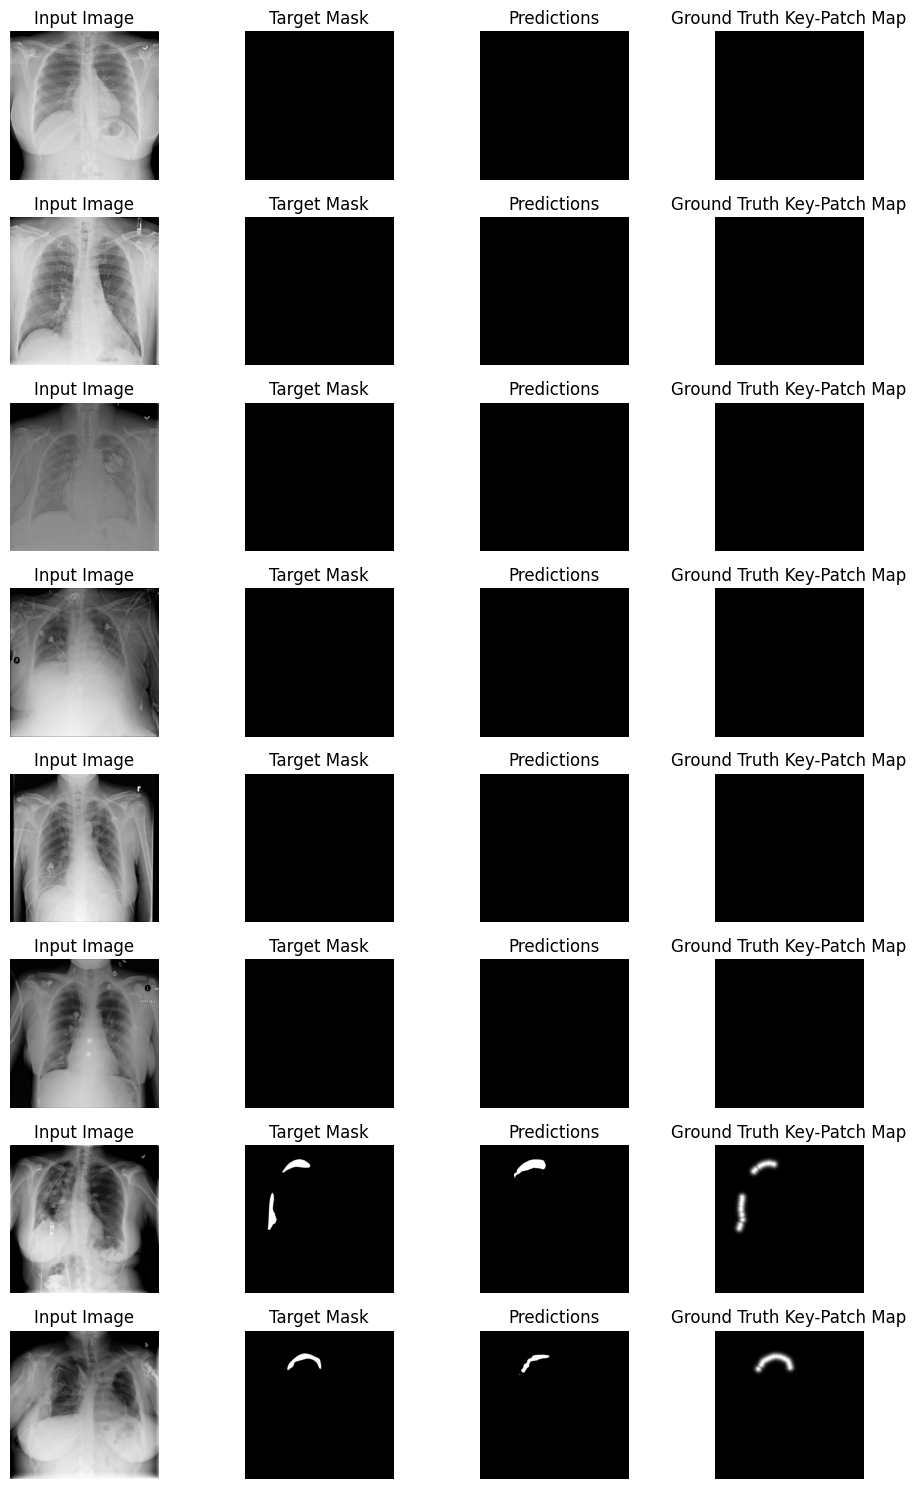

  0%|          | 1/268 [00:10<45:50, 10.30s/it]

images_resized_512 - Shape:  torch.Size([8, 3, 512, 512])  || type:  <class 'torch.Tensor'>
preds1 - Shape:  torch.Size([8, 1, 512, 512])  || device:  0
masks_resized_512 - Shape:  torch.Size([8, 1, 512, 512])  || type:  <class 'torch.Tensor'>
---------------------------- Dice Scores -----------------------------------
dice_scores_512 - Shape:  torch.Size([8])  || type:  <class 'torch.Tensor'>
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3437, 1.0000],
       device='cuda:0')


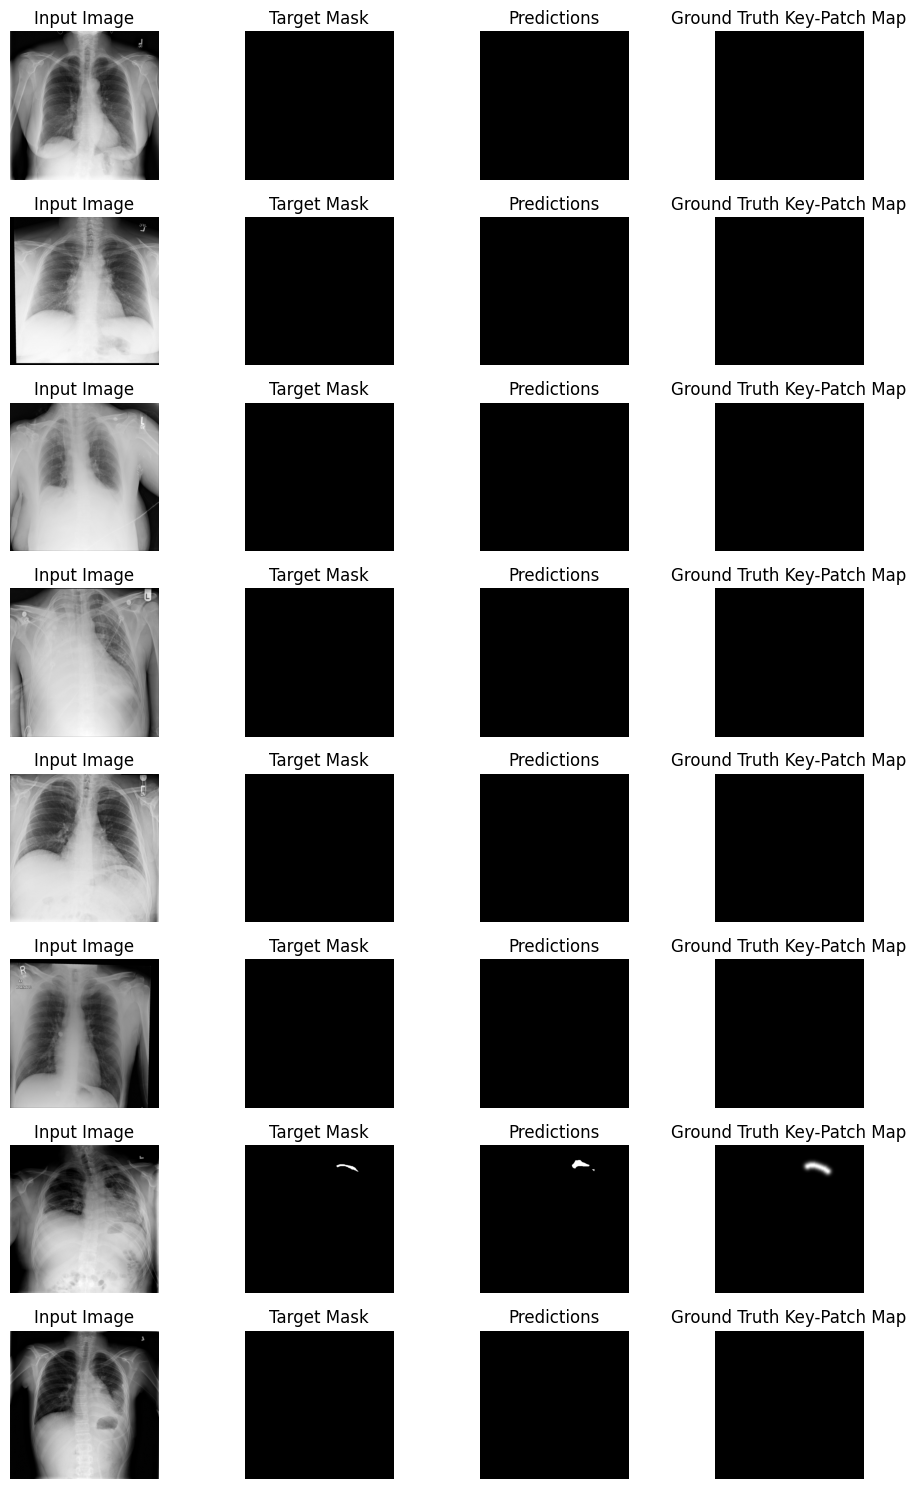

  0%|          | 1/268 [00:13<59:08, 13.29s/it]


In [121]:
from torchvision.transforms import Resize
from torchvision.utils import make_grid


def generate_predictions(model, images):
    with torch.inference_mode():
        predictions = model(images.to(DEVICE))
        predictions = torch.sigmoid(predictions[0])
        return predictions

def visualize_predictions(images, target_masks, points, preds1):
    images = images.cpu() # shape: [8, 3, 1024, 1024] or [8, 3, 512, 512]
    target_masks = target_masks.cpu() # shape: [8, 1, 1024, 1024] or [8, 1, 512, 512]
    preds1 = preds1.cpu() # shape: [8, 1, 1024, 1024] or [8, 1, 512, 512]
    points = points.cpu()

    fig, axes = plt.subplots(VALID_BATCH_SIZE, 4, figsize=(10, 15))
    # fig, axes = plt.subplots(VALID_BATCH_SIZE, 4)

    for i in range(VALID_BATCH_SIZE):
        # axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].imshow(images[i, 0], cmap="gray")
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(target_masks[i, 0], cmap="gray")
        axes[i, 1].set_title("Target Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(preds1[i, 0], cmap="gray")
        axes[i, 2].set_title("Predictions")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(points[i, 0], cmap="gray")
        axes[i, 3].set_title("Ground Truth Key-Patch Map")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

"""----------------------------- Inference --------------------------------"""

metrics512 = defaultdict(float)

tk0 = tqdm(val_dataloader, total=len(val_dataloader))
count=0
with torch.inference_mode():
    for b_idx, data in enumerate(tk0):
        # if b_idx == 1: # b_idx=710 has one positive case if batch_size=3
        images_resized_512 = data["image"] # shape: [8, 3, 1024, 1024]
        print("images_resized_512 - Shape: ", images_resized_512.shape, " || type: ", type(images_resized_512))

        # Generate predictions
        preds512 = generate_predictions(model512, images_resized_512)  # shape: [1, 1, 512, 512]
        print("preds1 - Shape: ", preds512.shape, " || device: ", preds512.get_device())

        # mask preprocessing
        masks_resized_512 = data["mask"]
        print("masks_resized_512 - Shape: ", masks_resized_512.shape, " || type: ", type(masks_resized_512))

        binarizer_fn = TripletMaskBinarization(TRIPLET_THRESHOLDS)
        mask_generator512 = binarizer_fn.transform(preds512)
        used_thresholds = binarizer_fn.thresholds

        for current_thr, current_mask in zip(used_thresholds, mask_generator512):
            current_metric = metric(current_mask.cpu().numpy(), masks_resized_512.cpu().numpy()).item()
            current_thr = tuple(current_thr)
            metrics512[current_thr] = (metrics512[current_thr] * b_idx + current_metric) / (b_idx + 1)

        best_threshold512 = max(metrics512, key=metrics512.get)
        best_metric512 = metrics512[best_threshold512]
        print("---------------------------- Dice Scores -----------------------------------")
        # dice_scores_512 = dice_metric(ensemble_preds512, masks_resized_512.to(DEVICE), per_image=True)
        binarizer_fn512 = TripletMaskBinarizationInference([best_threshold512])

        seg_mask512 = binarizer_fn512.transform(preds512)

        disp_512_classifications(seg_mask512.squeeze(1))

        dice_scores_512 = dice_metric(seg_mask512.to(DEVICE), masks_resized_512.to(DEVICE), per_image=True)
        print("dice_scores_512 - Shape: ", dice_scores_512.shape, " || type: ", type(dice_scores_512))
        print(dice_scores_512)
        visualize_predictions(images_resized_512, masks_resized_512, data['point'], seg_mask512)
        count += 1
        if count==2:
          break

In [125]:
tk0 = tqdm(val_dataloader, total=len(val_dataloader))
dices = AverageMeter()
img_dice_values = []
neg_mask = torch.zeros(1, 1, 512, 512).to(DEVICE)
with torch.inference_mode():
    for b_idx, data in enumerate(tk0):
        batch_512 = data["image"].to(DEVICE)
        mask_512 = data["mask"].to(DEVICE)
        if b_idx != 267:
          for i in range(BATCH_SIZE):
              curr_img = batch_512[i].unsqueeze(0)
              #print("curr_img.shape ", curr_img.shape)
              pred_prob512 = model512(curr_img)
              pred_prob512 = pred_prob512[0]
              # print(pred_prob512.shape)
              binarizer_fn = TripletMaskBinarization(TRIPLET_THRESHOLDS)
              mask_generator512 = binarizer_fn.transform(preds512)
              used_thresholds = binarizer_fn.thresholds

              for current_thr, current_mask in zip(used_thresholds, mask_generator512):
                  current_metric = metric(current_mask.cpu().numpy(), masks_resized_512.cpu().numpy()).item()
                  current_thr = tuple(current_thr)
                  metrics512[current_thr] = (metrics512[current_thr] * b_idx + current_metric) / (b_idx + 1)

              best_threshold512 = max(metrics512, key=metrics512.get)
              best_metric512 = metrics512[best_threshold512]
              # print("---------------------------- Dice Scores -----------------------------------")
              # dice_scores_512 = dice_metric(ensemble_preds512, masks_resized_512.to(DEVICE), per_image=True)
              binarizer_fn512 = TripletMaskBinarizationInference([best_threshold512])

              # seg_mask512 = binarizer_fn512.transform(preds512)
              seg_mask512 = binarizer_fn512.transform(pred_prob512)
              # print(seg_mask512.shape)

              dice = dice_metric(seg_mask512, mask_512[i]).item()
              dices.update(dice, val_dataloader.batch_size)
              img_dice_values.append(dice)
        else:
          for i in range(6):
              curr_img = batch_512[i].unsqueeze(0)
              #print("curr_img.shape ", curr_img.shape)
              pred_prob512 = model512(curr_img)
              pred_prob512 = pred_prob512[0]
              # print(pred_prob512.shape)
              binarizer_fn = TripletMaskBinarization(TRIPLET_THRESHOLDS)
              mask_generator512 = binarizer_fn.transform(preds512)
              used_thresholds = binarizer_fn.thresholds

              for current_thr, current_mask in zip(used_thresholds, mask_generator512):
                  current_metric = metric(current_mask.cpu().numpy(), masks_resized_512.cpu().numpy()).item()
                  current_thr = tuple(current_thr)
                  metrics512[current_thr] = (metrics512[current_thr] * b_idx + current_metric) / (b_idx + 1)

              best_threshold512 = max(metrics512, key=metrics512.get)
              best_metric512 = metrics512[best_threshold512]
              # print("---------------------------- Dice Scores -----------------------------------")
              # dice_scores_512 = dice_metric(ensemble_preds512, masks_resized_512.to(DEVICE), per_image=True)
              binarizer_fn512 = TripletMaskBinarizationInference([best_threshold512])

              # seg_mask512 = binarizer_fn512.transform(preds512)
              seg_mask512 = binarizer_fn512.transform(pred_prob512)
              # print(seg_mask512.shape)

              dice = dice_metric(seg_mask512, mask_512[i]).item()
              dices.update(dice, val_dataloader.batch_size)
              img_dice_values.append(dice)

        tk0.set_postfix(dice_score=dices.avg)
    print(f"Validation set dice score: {dices.avg}")

  0%|          | 0/268 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 268/268 [15:34<00:00,  3.49s/it, dice_score=0.838]

Validation set dice score: 0.8384941262023455


In [ ]:
def metric(probability, truth):
    probability = torch.from_numpy(probability)
    truth = torch.from_numpy(truth)
    # print(probability.shape, truth.shape)
    if probability.shape[0] == truth.shape[0]: # checking for batch size mismatches in the code for image & mask
        batch_size = probability.shape[0]
    with torch.no_grad():
        probability = probability.view(batch_size, -1) # probability's size is [8, 1*512*512]
        truth = truth.view(batch_size, -1)             # truth's size is [8, 1*512*512]
        assert(probability.shape == truth.shape)

        p = probability.float() # prob_preds already comes in binarized.
        t = (truth > 0.5).float()

        t_sum = t.sum(-1) # t_sum size is 8 # Each value in the vector represents the sum of all pixels in one mask
        p_sum = p.sum(-1) # p_sum size is 8 # Each value in the vector represents the sum of all elements in one pred_probs
        neg_index = torch.nonzero(t_sum == 0) # indices of masks which are negative.
        pos_index = torch.nonzero(t_sum >= 1) # indices of masks which are positive.

        dice_neg = (p_sum == 0).float() # tensor of size 8
        """
        if t_sum = torch.tensor([0.0, 1000.0, 0.0, 600.0, 720.0, 420.0, 0.0, 0.0]), then dice_neg = tensor([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0])
        """
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1)) # tensor of size 8

        dice_neg = dice_neg[neg_index] # selects elements of dice_neg acc to the indices in neg_index, it can have more than one element.
        dice_pos = dice_pos[pos_index] # similar to the above code line.
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index) # no. of negative masks in a batch
        num_pos = len(pos_index) # no. of positive masks in a batch

    return dice.mean()

In [ ]:
print(val_dataloader.batch_size)

# Classification Metrics FP

In [143]:
def predict_512(batch_images, batch_masks, b_idx, metrics512):
    """
    Generate segmentation predictions for a batch by processing
    each image separately, applying threshold selection per sample.

    Args:
        batch_images (torch.Tensor): Batch of input images.
        batch_masks (torch.Tensor): Corresponding ground truth masks.
        b_idx (int): Batch index (used for running average metric updates).
        metrics512 (dict): Dictionary storing running metrics for each threshold.

    Returns:
        torch.Tensor: A tensor stacking individual segmentation masks.
    """
    seg_masks_list = []
    BATCH_SIZE = batch_images.size(0)

    for i in range(BATCH_SIZE):
        # Process one image at a time.
        curr_img = batch_images[i].unsqueeze(0)   # Shape [1, C, H, W]
        mask_target = batch_masks[i].unsqueeze(0)   # Shape [1, 1, H, W]

        # Generate prediction probability map.
        pred_prob512 = model512(curr_img)
        # Remove extra batch dimension.
        pred_prob512 = pred_prob512[0]

        # Initialize binarization function for thresholding.
        binarizer_fn = TripletMaskBinarization(TRIPLET_THRESHOLDS)
        # Compute candidate masks for each threshold.
        mask_generator512 = binarizer_fn.transform(pred_prob512)
        used_thresholds = binarizer_fn.thresholds

        # Update running metrics for threshold selection.
        for current_thr, current_mask in zip(used_thresholds, mask_generator512):
            current_metric = metric(current_mask.cpu().numpy(), mask_target.cpu().numpy()).item()
            current_thr = tuple(current_thr)
            # If the threshold has not been seen before, start from 0.
            metrics512[current_thr] = (metrics512.get(current_thr, 0) * b_idx + current_metric) / (b_idx + 1)

        # Select the best threshold based on the running average.
        best_threshold512 = max(metrics512, key=metrics512.get)
        # Use a dedicated binarization function for inference with the best threshold.
        binarizer_fn512 = TripletMaskBinarizationInference([best_threshold512])
        seg_mask512 = binarizer_fn512.transform(pred_prob512)

        # Append the segmentation mask for the current image.
        seg_masks_list.append(seg_mask512)

    # Stack all individual segmentation masks into one tensor.
    seg_masks = torch.stack(seg_masks_list)
    return seg_masks


def calculate_classification_metrics_for_validation_set(model, dataloader, device):
    """
    Calculate classification and dice metrics on the entire validation set.
    The function processes each image individually, selecting the best threshold,
    computing segmentation masks, and then computing the dice coefficient with
    respect to the ground truth mask.

    Args:
        model (torch.nn.Module): The trained segmentation model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the validation set.
        device (torch.device): Device on which to perform computations.

    Returns:
        dict: Dictionary containing the False Positives, Recall, F1 Score,
              Specificity, and the average Validation Dice Score.
    """
    # Initialize accumulators for classification metrics.
    TP_total = 0
    FP_total = 0
    TN_total = 0
    FN_total = 0

    # Prepare accumulators for the dice metric.
    dices = AverageMeter()
    img_dice_values = []

    # Initialize dictionary to keep running threshold metrics.
    metrics512 = {}

    model.eval()
    tk0 = tqdm(dataloader, total=len(dataloader))

    with torch.inference_mode():
        for b_idx, data in enumerate(tk0):
            inputs = data['image'].to(device)
            targets = data['mask'].to(device)

            # Get segmentation predictions by processing each sample individually.
            predictions = predict_512(inputs, targets, b_idx, metrics512)
            # print(predictions.shape)
            # Adjust shape for metric computations.
            predictions = predictions.squeeze(1).int()
            targets = targets.int()
            # print(f"squeezed predictions: {predictions.shape} | squeezed targets: {targets.shape}")
            # Compute image-level binary classification metrics.
            preds_positive = (predictions.sum(dim=(2, 3)) > 0).squeeze(1).int()
            targets_positive = (targets.sum(dim=(2, 3)) > 0).squeeze(1).int()
            # print(preds_positive.shape, targets_positive.shape)
            TP_total += ((preds_positive == 1) & (targets_positive == 1)).sum().item()
            FP_total += ((preds_positive == 1) & (targets_positive == 0)).sum().item()
            TN_total += ((preds_positive == 0) & (targets_positive == 0)).sum().item()
            FN_total += ((preds_positive == 0) & (targets_positive == 1)).sum().item()

    # Compute overall classification metrics.
    accuracy = (TP_total+TN_total)/(TP_total+TN_total+FP_total+FN_total)
    precision = (TP_total)/(TP_total+FP_total)
    recall = TP_total / (TP_total + FN_total + 1e-6)
    specificity = TN_total / (TN_total + FP_total + 1e-6)
    precision = TP_total / (TP_total + FP_total + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    metrics_output = {
        "Accuracy": accuracy,
        "Precision": precision,
        "False Positives": FP_total,
        "Recall": recall,
        "F1 Score": f1_score,
        "Specificity": specificity,
    }
    return metrics_output

In [144]:
metrics = calculate_classification_metrics_for_validation_set(model.to(DEVICE), val_dataloader, DEVICE)

  0%|          | 0/268 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 268/268 [04:42<00:00,  1.05s/it]


In [145]:
print(metrics)

{'Accuracy': 0.9070961718020542, 'Precision': 0.9156626478443897, 'False Positives': 28, 'Recall': 0.6399999986526316, 'F1 Score': 0.7534071966086747, 'Specificity': 0.9832033587383302}
